In [1]:
import os
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from scipy.stats import ttest_ind
import statsmodels
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import scipy.cluster.hierarchy as sch
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sys
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, roc_auc_score,
    classification_report, roc_curve
)
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test
from tqdm import tqdm

In [2]:
mRNA  = pd.read_csv(r'LUAD/Aligned/LUAD_CNV_aligned.csv', index_col=0)
miRNA = pd.read_csv(r'LUAD/Aligned/LUAD_miRNA_aligned.csv', index_col=0)
Methy = pd.read_csv(r'LUAD/Aligned/LUAD_Methy_aligned.csv', index_col=0)
CNV   = pd.read_csv(r'LUAD/Aligned/LUAD_CNV_aligned.csv', index_col=0)
survival_df = pd.read_csv(r'LUAD/Aligned/survival_LUAD.csv', index_col=0)
merged = pd.concat([mRNA, miRNA, Methy, CNV], axis=0)
merged = merged.T
merged = merged.loc[:, ~merged.columns.duplicated()]
merged = merged.dropna(axis=1)
print(f"Merged dataset shape: {merged.shape}") 

Merged dataset shape: (450, 15569)


In [3]:
df_cnv =   pd.read_csv(r'LUAD/Original/LUAD_CNV.csv', index_col=0, low_memory=False)
df_mrna =  pd.read_csv(r'LUAD/Original/LUAD_mRNA.csv', index_col=0, low_memory=False)
df_mirna = pd.read_csv(r'LUAD/Original/LUAD_miRNA.csv', index_col=0, low_memory=False)
df_methy = pd.read_csv(r'LUAD/Original/LUAD_Methy.csv', index_col=0, low_memory=False)
survival = pd.read_csv(r'LUAD/Original/survival_LUAD.csv', index_col=0, low_memory=False)

In [4]:
for df in [df_cnv, df_mrna, df_mirna, df_methy]:
    df.columns = df.columns.str.strip()
    df.index = df.index.str.strip()
df_cnv = df_cnv.apply(pd.to_numeric, errors='coerce')
df_mrna = df_mrna.apply(pd.to_numeric, errors='coerce')
df_mirna = df_mirna.apply(pd.to_numeric, errors='coerce')
df_methy = df_methy.apply(pd.to_numeric, errors='coerce')
shared_samples = set(df_cnv.columns) & set(df_mrna.columns) & set(df_mirna.columns) & set(df_methy.columns)
shared_samples = sorted(list(shared_samples))  
df_cnv = df_cnv[shared_samples]
df_mrna = df_mrna[shared_samples]
df_mirna = df_mirna[shared_samples]
df_methy = df_methy[shared_samples]
def normalize(df):
    df_z = pd.DataFrame(StandardScaler().fit_transform(df.T), index=df.columns, columns=df.index).T
    return df_z

df_cnv_z = normalize(df_cnv)
df_mrna_z = normalize(df_mrna)
df_mirna_z = normalize(df_mirna)
df_methy_z = normalize(df_methy)

print("Loaded, cleaned, subsetted, and normalized.")


Loaded, cleaned, subsetted, and normalized.


Top 20 most variable genes:
ZNF639      1.002227
ELOVL5      1.002227
ADAM17      1.002227
PCDHGB6     1.002227
NXPH4       1.002227
THSD7A      1.002227
GAMT        1.002227
DTNBP1      1.002227
KIAA0368    1.002227
RMI1        1.002227
MDFIC       1.002227
ITIH3       1.002227
HIST1H4C    1.002227
RNF144A     1.002227
NKX3-2      1.002227
NDUFB6      1.002227
MYCBP2      1.002227
C5orf63     1.002227
FPR2        1.002227
ZNF772      1.002227
dtype: float64


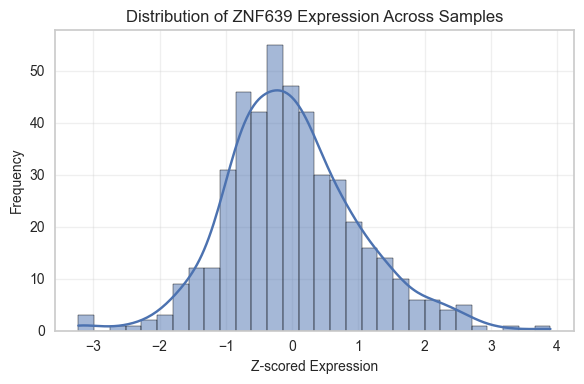

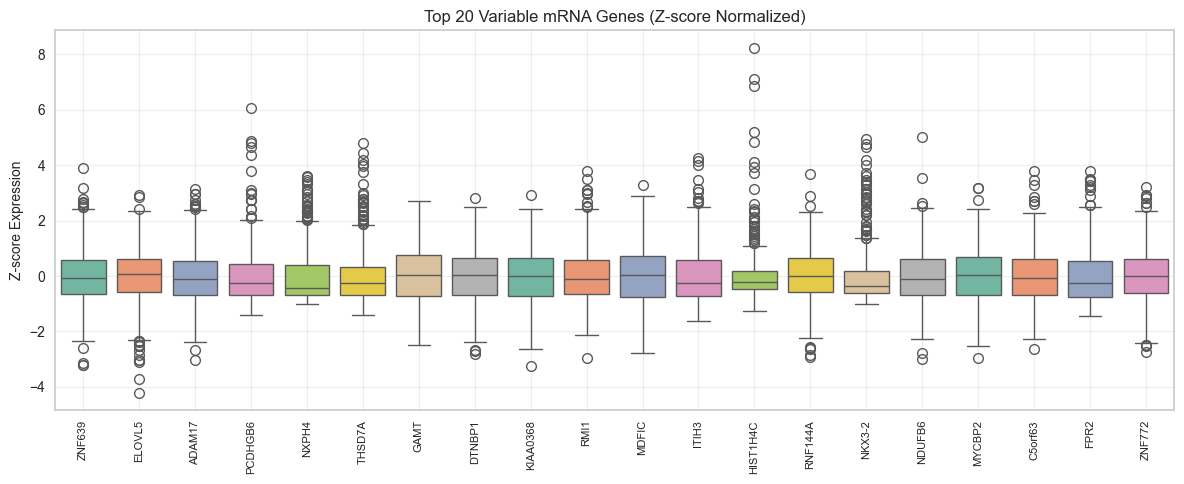

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

gene_variances = df_mrna_z.var(axis=1)
top_genes = gene_variances.sort_values(ascending=False).head(20)
print("Top 20 most variable genes:")
print(top_genes)
example_gene = top_genes.index[0]
plt.figure(figsize=(6, 4))
sns.histplot(df_mrna_z.loc[example_gene], bins=30, kde=True, color="#4C72B0")
plt.title(f"Distribution of {example_gene} Expression Across Samples", fontsize=12)
plt.xlabel("Z-scored Expression", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=df_mrna_z.loc[top_genes.index].T, palette="Set2")  
plt.title("Top 20 Variable mRNA Genes (Z-score Normalized)", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Z-score Expression", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


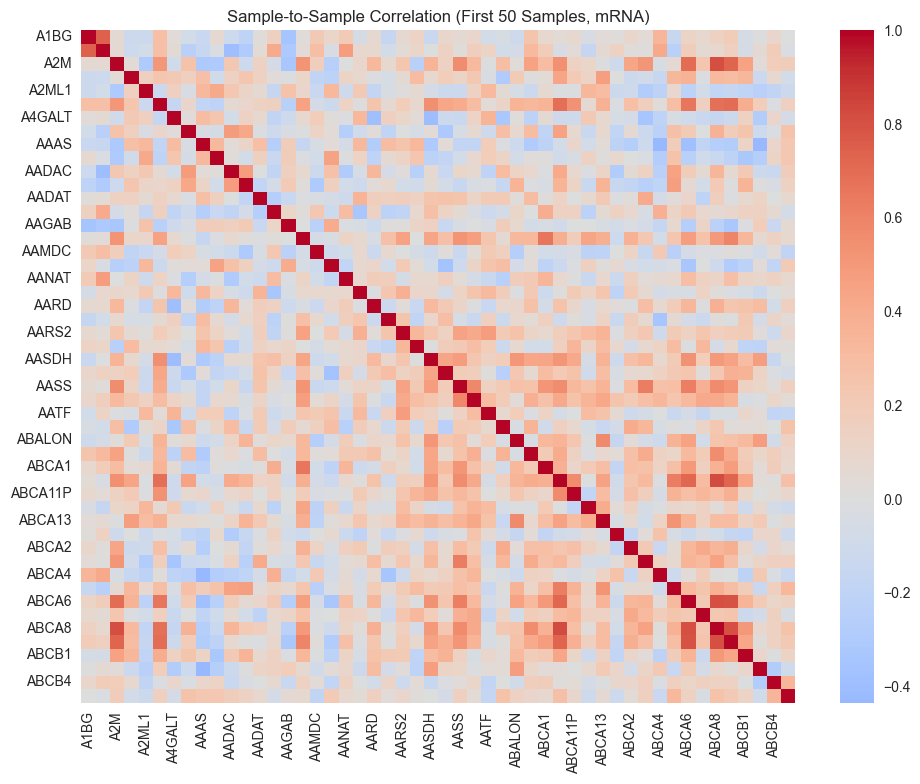

In [6]:
subset_corr = df_mrna_z.T.iloc[:50, :50].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(subset_corr, cmap='coolwarm', center=0)
plt.title("Sample-to-Sample Correlation (First 50 Samples, mRNA)")
plt.tight_layout()
plt.show()


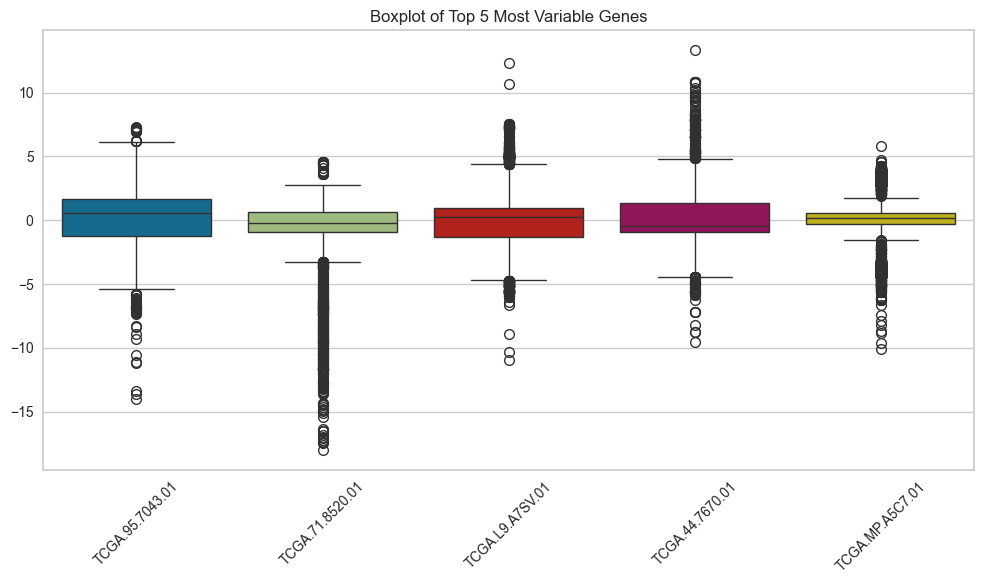

In [7]:
top_genes = mRNA.var().sort_values(ascending=False).head(5).index
plt.figure(figsize=(10, 6))
sns.boxplot(data=mRNA[top_genes])
plt.title("Boxplot of Top 5 Most Variable Genes")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

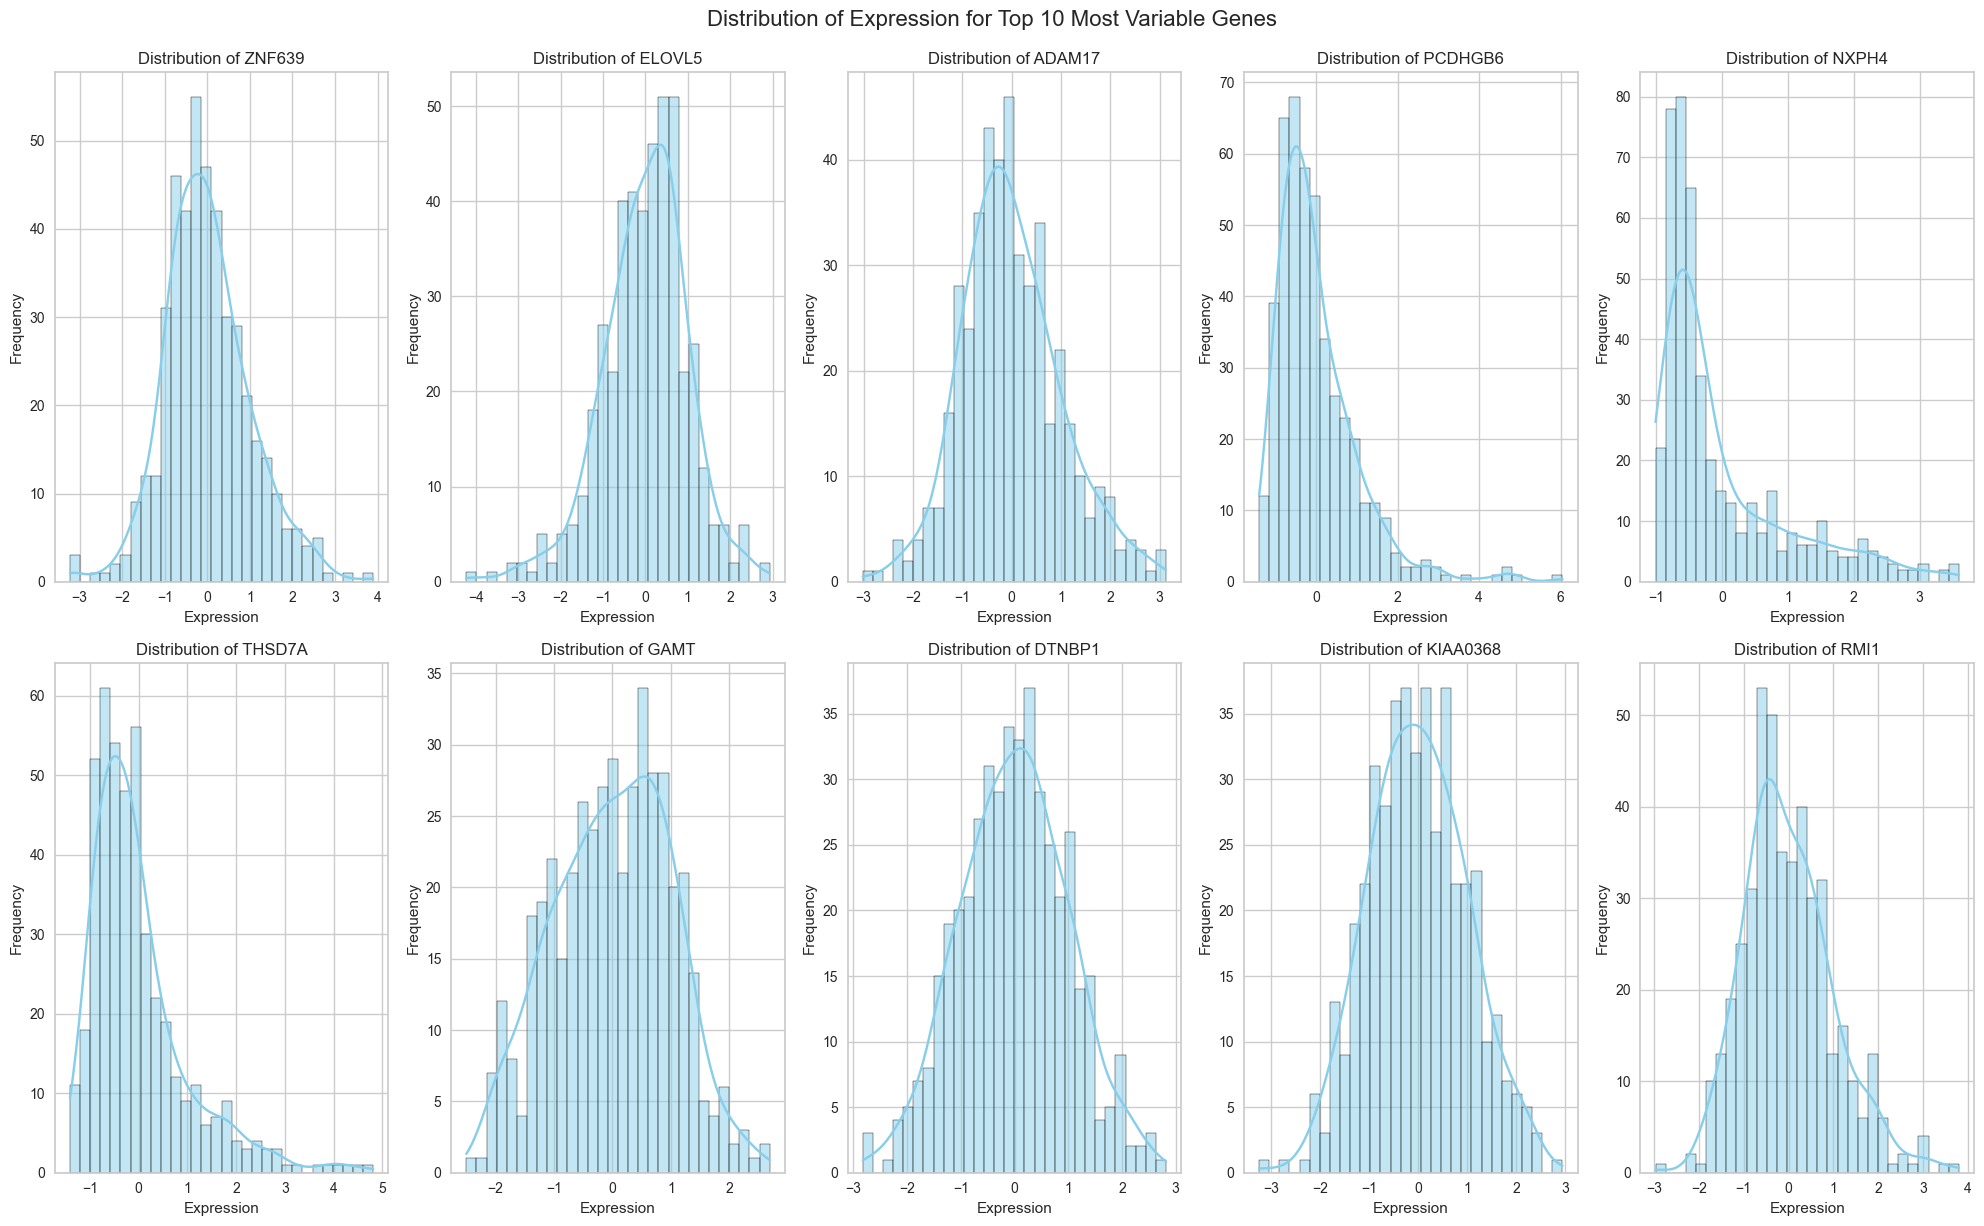

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
gene_variances = df_mrna_z.var(axis=1)
top10_genes = gene_variances.sort_values(ascending=False).head(10).index
plt.figure(figsize=(20, 12))
for i, gene in enumerate(top10_genes):
    plt.subplot(2, 5, i + 1)
    sns.histplot(df_mrna_z.loc[gene], kde=True, bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {gene}')
    plt.xlabel('Expression')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.suptitle("Distribution of Expression for Top 10 Most Variable Genes", fontsize=16, y=1.02)
plt.show()



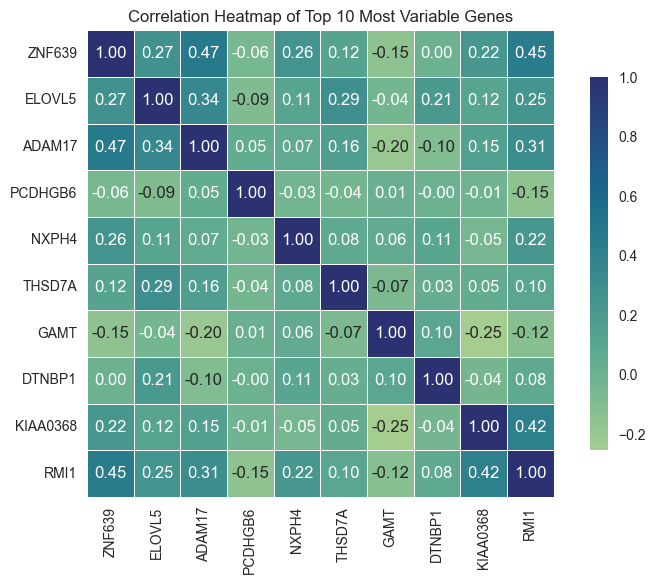

In [9]:
corr = df_mrna_z.loc[top10_genes].T.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='crest', fmt=".2f", linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title("Correlation Heatmap of Top 10 Most Variable Genes")
plt.tight_layout()
plt.show()


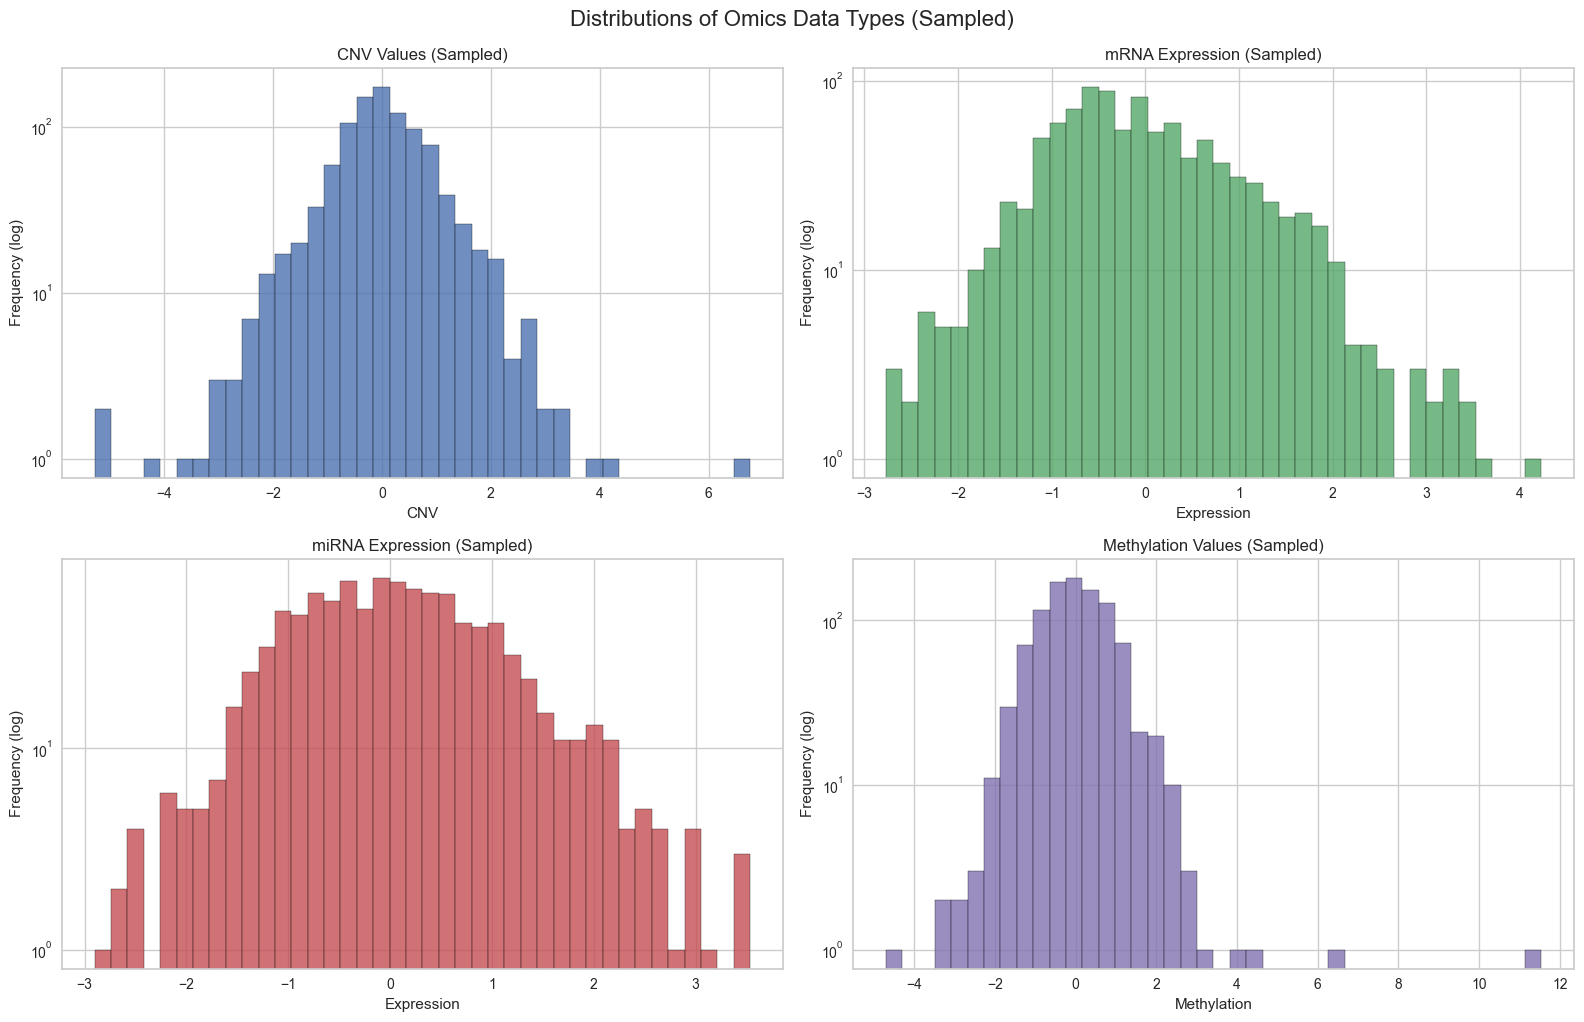

In [10]:
import matplotlib.pyplot as plt
import numpy as np
sample_size = 1000
cnv_sample = np.random.choice(df_cnv.values.flatten()[~np.isnan(df_cnv.values.flatten())], size=sample_size, replace=False)
mrna_sample = np.random.choice(df_mrna.values.flatten()[~np.isnan(df_mrna.values.flatten())], size=sample_size, replace=False)
mirna_sample = np.random.choice(df_mirna.values.flatten()[~np.isnan(df_mirna.values.flatten())], size=sample_size, replace=False)
methy_sample = np.random.choice(df_methy.values.flatten()[~np.isnan(df_methy.values.flatten())], size=sample_size, replace=False)
plt.figure(figsize=(16, 10))

# CNV
plt.subplot(2, 2, 1)
plt.hist(cnv_sample, bins=40, color="#4C72B0", edgecolor='black', alpha=0.8)
plt.yscale('log')
plt.title("CNV Values (Sampled)")
plt.xlabel("CNV")
plt.ylabel("Frequency (log)")

# mRNA
plt.subplot(2, 2, 2)
plt.hist(mrna_sample, bins=40, color="#55A868", edgecolor='black', alpha=0.8)
plt.yscale('log')
plt.title("mRNA Expression (Sampled)")
plt.xlabel("Expression")
plt.ylabel("Frequency (log)")

# miRNA
plt.subplot(2, 2, 3)
plt.hist(mirna_sample, bins=40, color="#C44E52", edgecolor='black', alpha=0.8)
plt.yscale('log')
plt.title("miRNA Expression (Sampled)")
plt.xlabel("Expression")
plt.ylabel("Frequency (log)")

# Methylation
plt.subplot(2, 2, 4)
plt.hist(methy_sample, bins=40, color="#8172B2", edgecolor='black', alpha=0.8)
plt.yscale('log')
plt.title("Methylation Values (Sampled)")
plt.xlabel("Methylation")
plt.ylabel("Frequency (log)")

plt.tight_layout()
plt.suptitle("Distributions of Omics Data Types (Sampled)", fontsize=16, y=1.02)
plt.show()


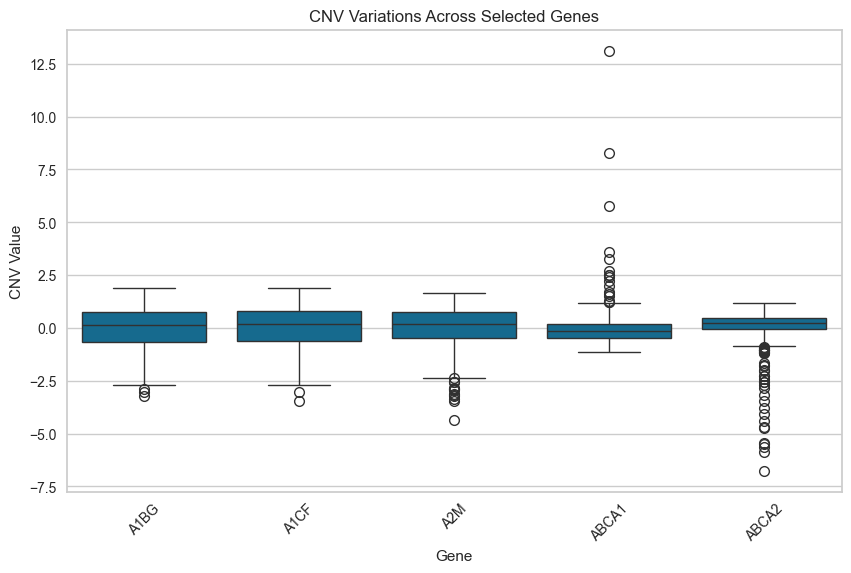

In [11]:
genes_to_plot = ["A1BG", "A1CF", "A2M", "ABCA1", "ABCA2"]
df_subset = df.loc[genes_to_plot].T.melt(var_name="Gene", value_name="CNV Value")

plt.figure(figsize=(10, 6))
sns.boxplot(x="Gene", y="CNV Value", data=df_subset)
plt.title("CNV Variations Across Selected Genes")
plt.xticks(rotation=45)
plt.show()

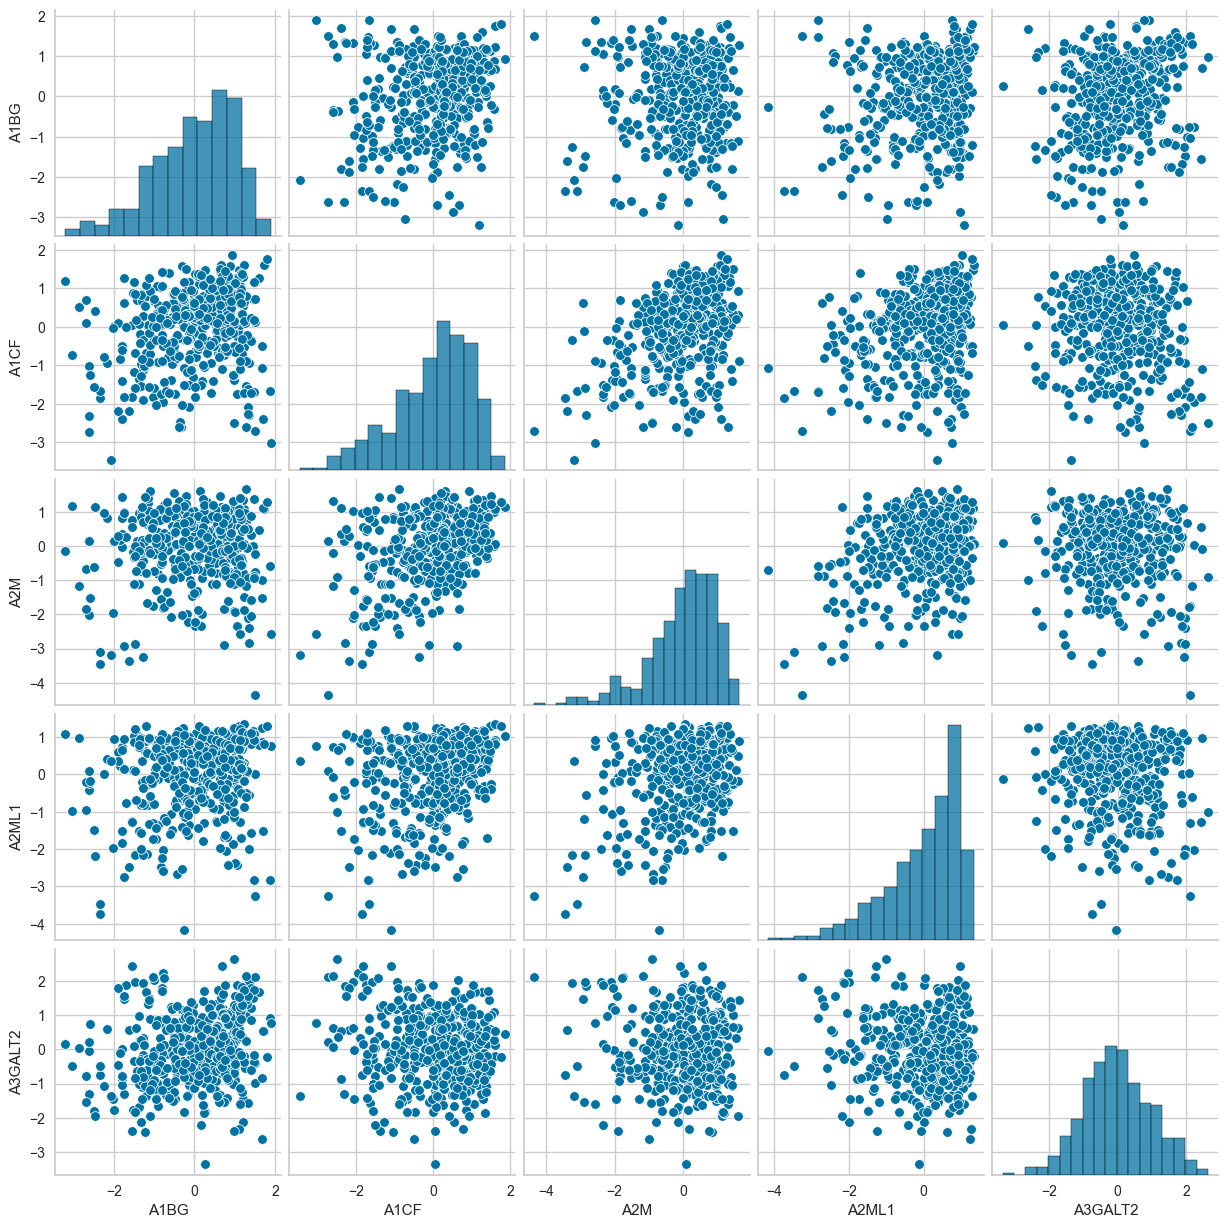

In [12]:
df_subset = df.iloc[:5].T
df_subset.columns = df.index[:5]

sns.pairplot(df_subset)
plt.show()

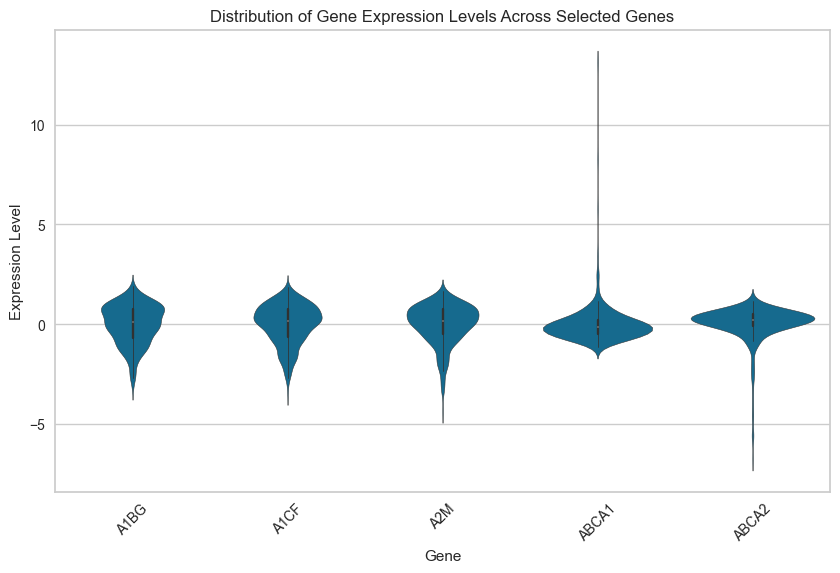

In [13]:
genes_to_plot = ["A1BG", "A1CF", "A2M", "ABCA1", "ABCA2"]
df_subset = df.loc[genes_to_plot].T.melt(var_name="Gene", value_name="Expression Level")

plt.figure(figsize=(10, 6))
sns.violinplot(x="Gene", y="Expression Level", data=df_subset)
plt.title("Distribution of Gene Expression Levels Across Selected Genes")
plt.xticks(rotation=45)
plt.show()

Generating plots for CNV...


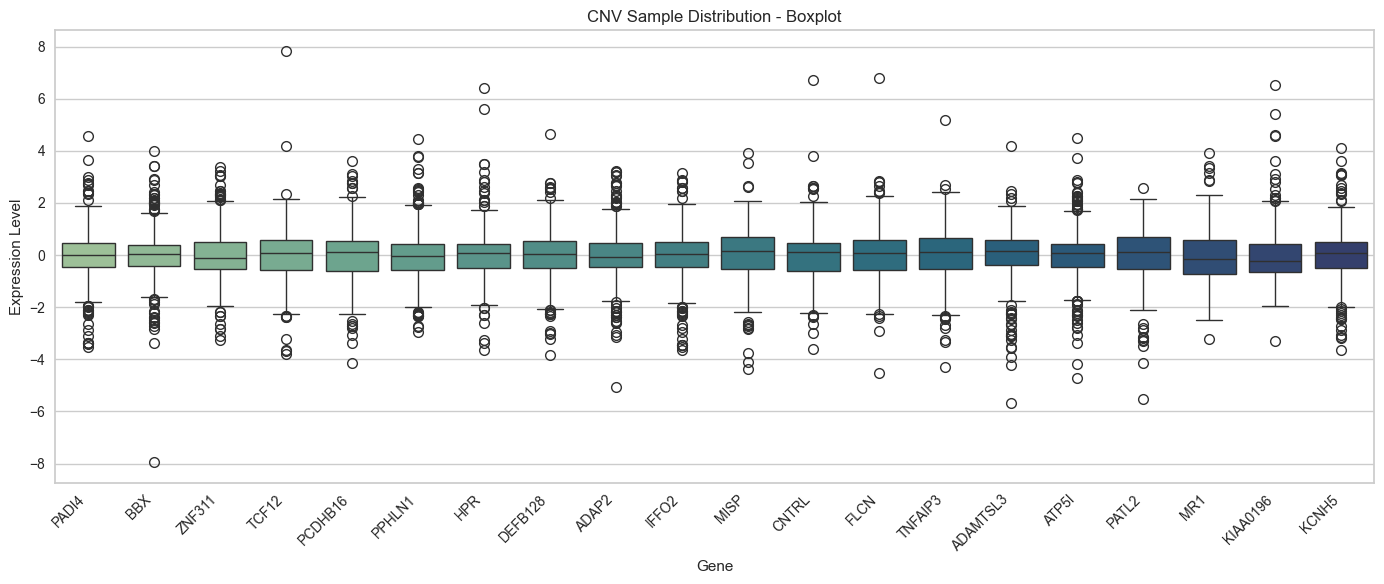

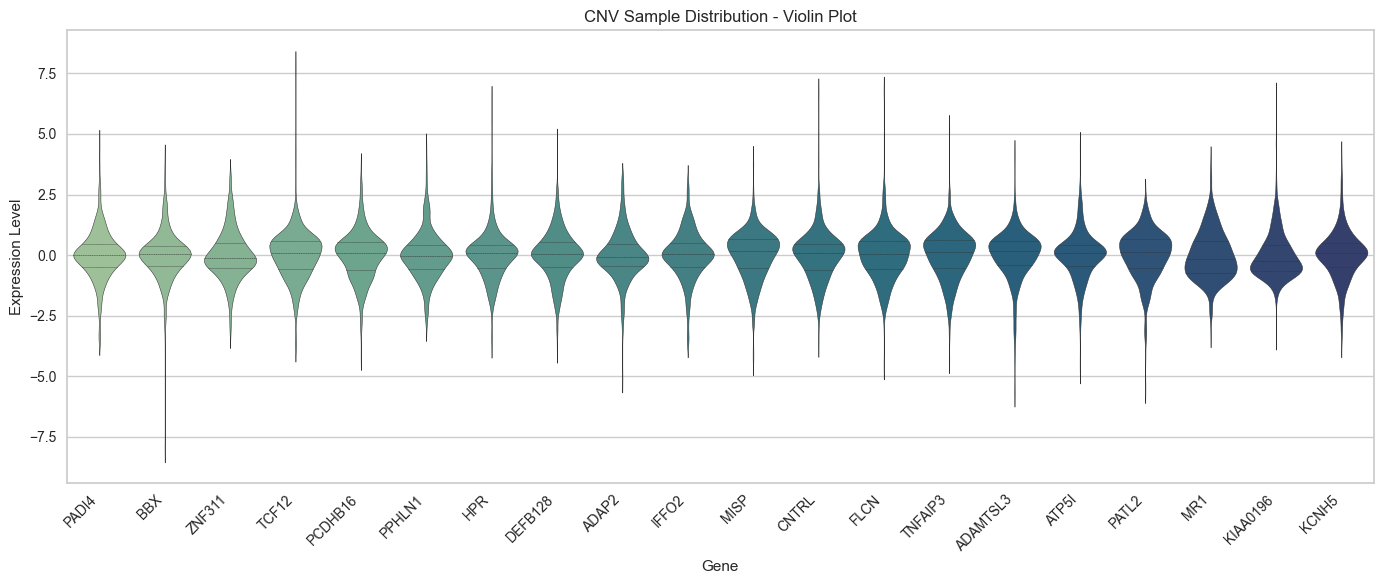

Generating plots for mRNA...


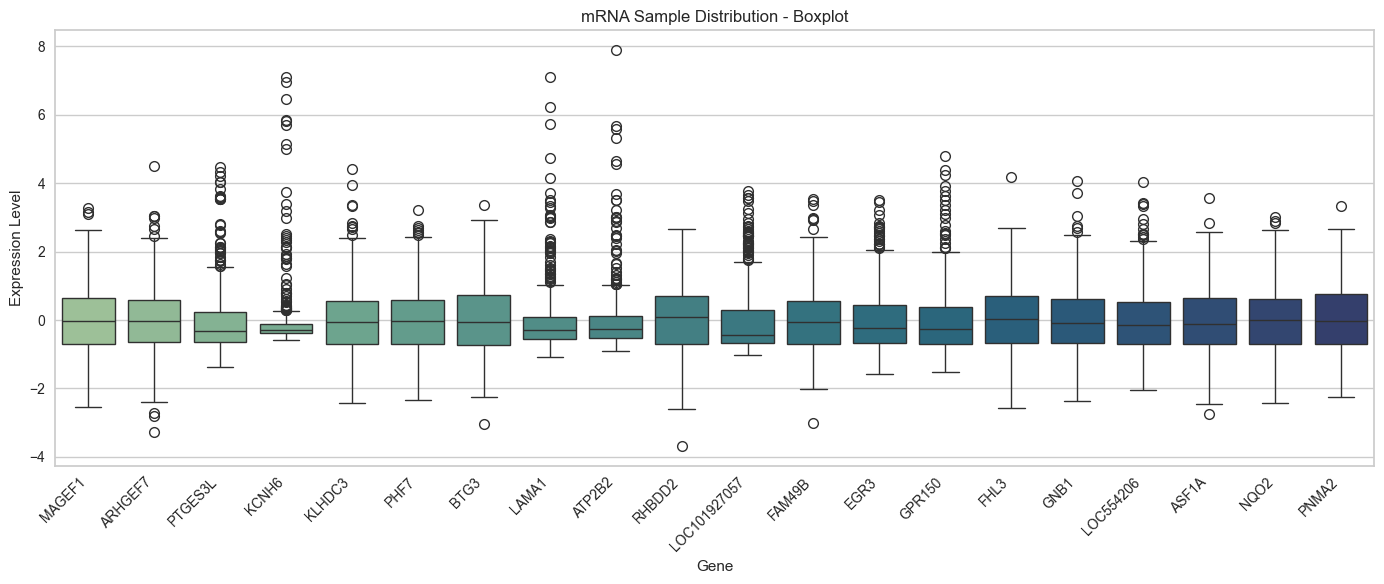

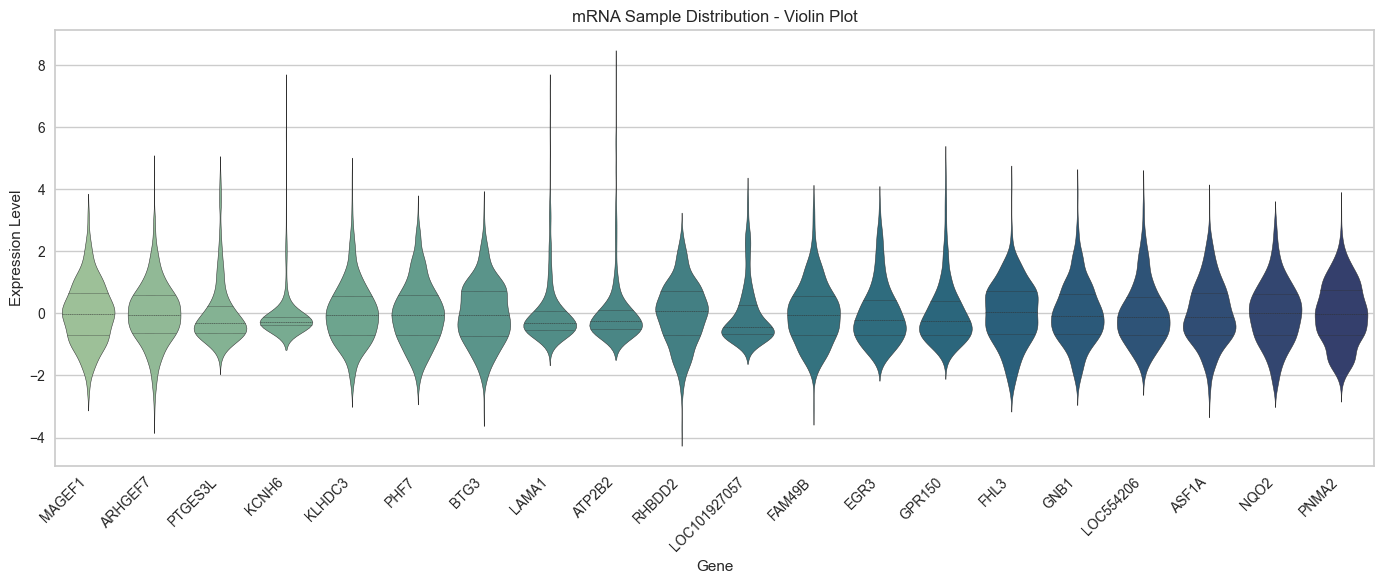

Generating plots for Methylation...


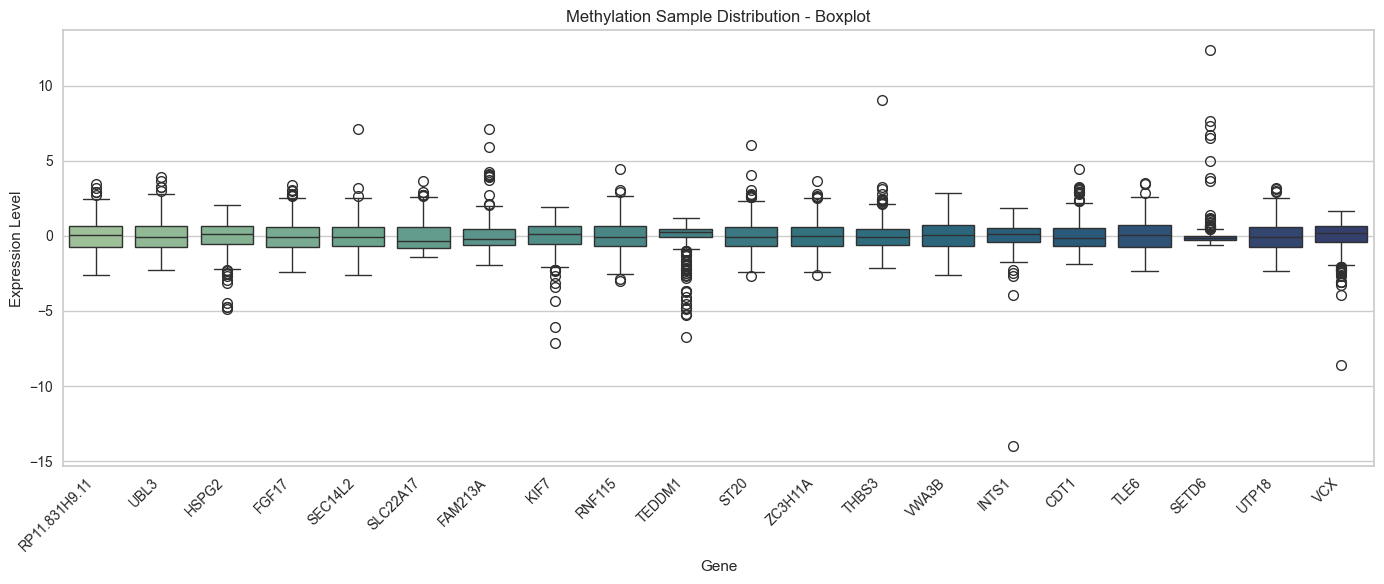

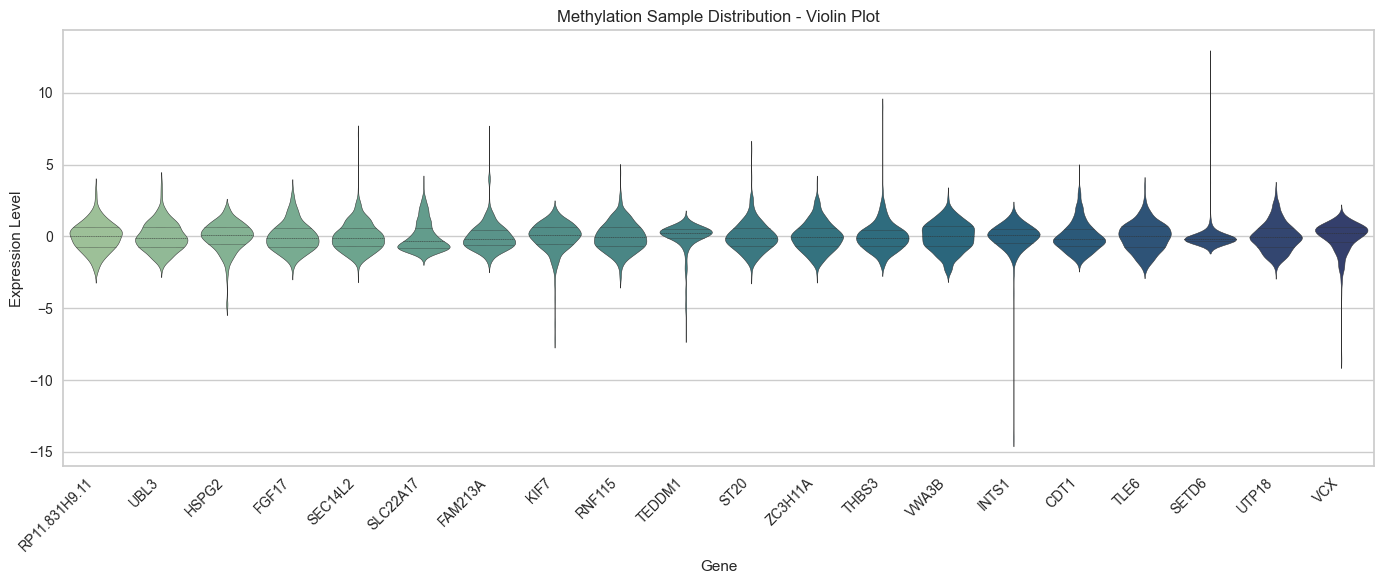

In [14]:
def plot_distribution(data, dataset_name, num_genes=20):
    data_long = data.T

    sampled_genes = np.random.choice(data_long.columns, size=min(num_genes, len(data_long.columns)), replace=False)
    data_sampled = data_long[sampled_genes]

    data_melted = data_sampled.melt(var_name="Gene", value_name="Expression")

    unique_genes = data_melted["Gene"].unique()
    palette = sns.color_palette("crest", n_colors=len(unique_genes))

    plt.figure(figsize=(14, 6))
    sns.boxplot(x="Gene", y="Expression", data=data_melted, palette=palette)
    plt.title(f"{dataset_name} Sample Distribution - Boxplot")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Gene")
    plt.ylabel("Expression Level")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 6))
    sns.violinplot(x="Gene", y="Expression", hue="Gene", data=data_melted,
                   palette=palette, inner="quartile", legend=False)
    plt.title(f"{dataset_name} Sample Distribution - Violin Plot")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Gene")
    plt.ylabel("Expression Level")
    plt.tight_layout()
    plt.show()

datasets = {
    "CNV": df_cnv_z,
    "mRNA": df_mrna_z,
    "Methylation": df_methy_z
}

for name, data in datasets.items():
    print(f"Generating plots for {name}...")
    plot_distribution(data, name, num_genes=20) 

In [15]:
class OmicsDataset(Dataset):
    def __init__(self, features, durations, events):
        self.x = torch.tensor(features.values, dtype=torch.float32)
        self.durations = torch.tensor(durations.values, dtype=torch.float32)
        self.events = torch.tensor(events.values, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.durations[idx], self.events[idx]

class CoxModel(nn.Module):
    def __init__(self, input_dim):
        super(CoxModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False)

    def forward(self, x):
        return self.linear(x)

def negative_partial_log_likelihood(preds, durations, events):
    order = torch.argsort(-durations)
    preds = preds[order]
    events = events[order]
    risk_set = torch.cumsum(torch.exp(preds), dim=0)
    log_likelihood = torch.sum((preds - torch.log(risk_set)) * events)
    return -log_likelihood

In [16]:
mRNA = pd.read_csv(r'./LUAD/Aligned/LUAD_mRNA_aligned.csv', index_col=0)
miRNA = pd.read_csv(r'./LUAD/Aligned/LUAD_miRNA_aligned.csv', index_col=0)
Methy = pd.read_csv(r'./LUAD/Aligned/LUAD_Methy_aligned.csv', index_col=0)
CNV = pd.read_csv(r'./LUAD/Aligned/LUAD_CNV_aligned.csv', index_col=0)

merged = pd.concat([mRNA, miRNA, Methy, CNV], axis=1)
merged = merged.loc[:, ~merged.columns.duplicated()]
merged = merged.dropna(axis=0)

survival = pd.read_csv('./LUAD/Aligned/survival_LUAD.csv')
survival.columns = survival.columns.str.strip().str.lower()
survival = survival.rename(columns={"survival_times": "duration", "event_observed": "event"})
survival = survival.loc[:len(merged)-1]

In [17]:
merged = merged.iloc[:len(survival)]

In [18]:
scaler = MinMaxScaler()
merged_scaled = pd.DataFrame(scaler.fit_transform(merged), index=merged.index, columns=merged.columns)

dataset = OmicsDataset(merged_scaled, survival["duration"], survival["event"])
loader = DataLoader(dataset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoxModel(input_dim=merged_scaled.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
for epoch in range(10000):
    model.train()
    total_loss = 0.0
    for x, d, e in loader:
        x, d, e = x.to(device, non_blocking=True), d.to(device, non_blocking=True), e.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        preds = model(x).squeeze()
        loss = negative_partial_log_likelihood(preds, d, e)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1:04d}, Loss: {total_loss:.4f}")

Epoch 0500, Loss: 347.2225
Epoch 1000, Loss: 285.3955
Epoch 1500, Loss: 252.6222
Epoch 2000, Loss: 231.7105
Epoch 2500, Loss: 208.9456
Epoch 3000, Loss: 196.2811
Epoch 3500, Loss: 184.9047
Epoch 4000, Loss: 167.3480
Epoch 4500, Loss: 162.2833
Epoch 5000, Loss: 148.6400
Epoch 5500, Loss: 145.8239
Epoch 6000, Loss: 138.5304
Epoch 6500, Loss: 130.9646
Epoch 7000, Loss: 133.2894
Epoch 7500, Loss: 123.2832
Epoch 8000, Loss: 117.0327
Epoch 8500, Loss: 113.2655
Epoch 9000, Loss: 115.1567
Epoch 9500, Loss: 112.9504
Epoch 10000, Loss: 104.3242


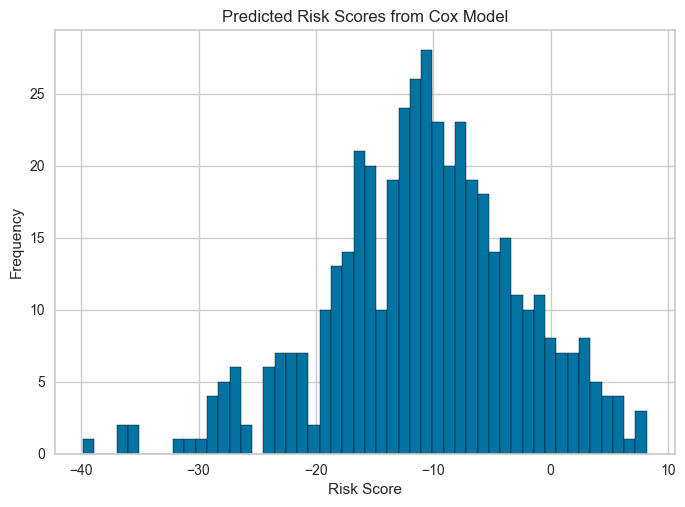

In [20]:
model.eval()
with torch.no_grad():
    all_preds = []
    for x, _, _ in loader:
        x = x.to(device)
        preds = model(x).squeeze().cpu().numpy()
        all_preds.extend(preds)

import matplotlib.pyplot as plt
plt.hist(all_preds, bins=50, edgecolor='black')
plt.title("Predicted Risk Scores from Cox Model")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")
plt.show()

In [21]:
model.eval()
with torch.no_grad():
    x_all = torch.tensor(merged_scaled.values, dtype=torch.float32).to(device)
    risk_scores = model(x_all).squeeze().cpu().numpy()

survival["risk_score"] = risk_scores
survival["risk_group"] = ["High" if x > survival["risk_score"].median() else "Low" for x in survival["risk_score"]]

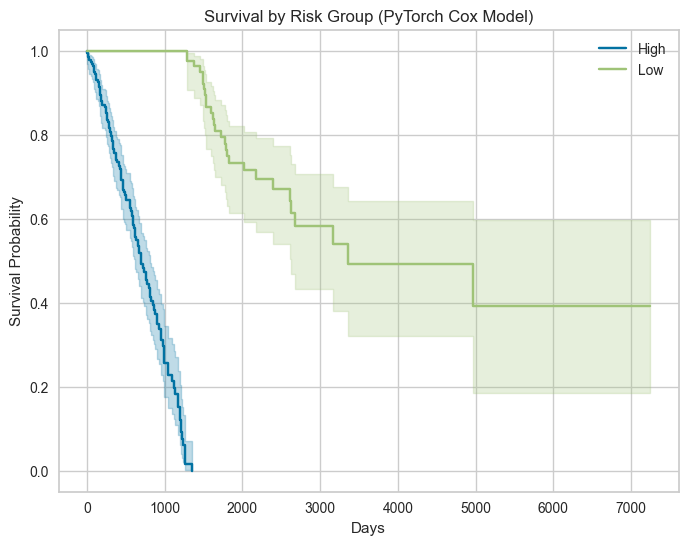

In [22]:
survival_eval = survival.copy()
survival_eval = survival_eval.dropna(subset=["duration", "event", "risk_score"])

kmf = KaplanMeierFitter()
plt.figure(figsize=(8, 6))
for group in ["High", "Low"]:
    mask = survival_eval["risk_group"] == group
    kmf.fit(survival_eval.loc[mask, "duration"], survival_eval.loc[mask, "event"], label=group)
    kmf.plot_survival_function()

plt.title("Survival by Risk Group (PyTorch Cox Model)")
plt.xlabel("Days")
plt.ylabel("Survival Probability")
plt.show()

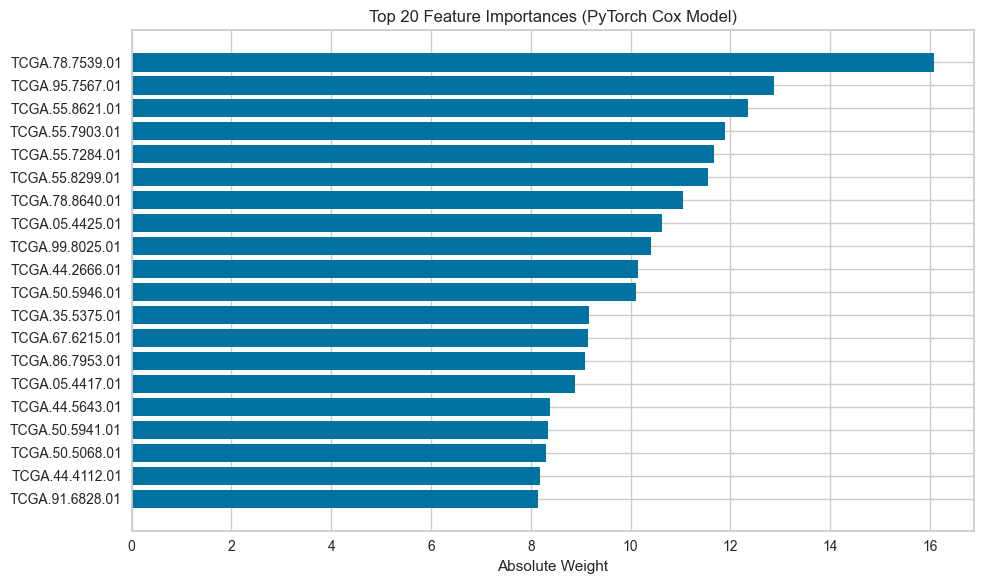

In [23]:
weights = model.linear.weight.detach().cpu().numpy().flatten()
abs_weights = np.abs(weights)
top_idx = np.argsort(abs_weights)[-20:][::-1]
top_genes = merged_scaled.columns[top_idx]
top_weights = abs_weights[top_idx]

plt.figure(figsize=(10, 6))
plt.barh(top_genes, top_weights)
plt.xlabel("Absolute Weight")
plt.title("Top 20 Feature Importances (PyTorch Cox Model)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [24]:
from sklearn.model_selection import KFold
from lifelines.utils import concordance_index

drop_cols = ['duration', 'event', 'risk_group']
features = merged_scaled.drop(columns=drop_cols, errors='ignore')

top_vars = features.var().sort_values(ascending=False).head(50).index
reduced_features = features[top_vars]

cox_data = reduced_features.copy()
cox_data['duration'] = survival['duration'].values
cox_data['event'] = survival['event'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)
concordances = []

for train_idx, test_idx in kf.split(cox_data):
    X_train = torch.tensor(cox_data.iloc[train_idx][top_vars].values, dtype=torch.float32).to(device)
    d_train = torch.tensor(cox_data.iloc[train_idx]['duration'].values, dtype=torch.float32).to(device)
    e_train = torch.tensor(cox_data.iloc[train_idx]['event'].values, dtype=torch.float32).to(device)

    X_test = torch.tensor(cox_data.iloc[test_idx][top_vars].values, dtype=torch.float32).to(device)
    d_test = cox_data.iloc[test_idx]['duration'].values
    e_test = cox_data.iloc[test_idx]['event'].values

    model_small = CoxModel(input_dim=50).to(device)
    optimizer = torch.optim.Adam(model_small.parameters(), lr=1e-3)

    for epoch in range(100):
        model_small.train()
        optimizer.zero_grad()
        preds = model_small(X_train).squeeze()
        loss = negative_partial_log_likelihood(preds, d_train, e_train)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        model_small.eval()
        preds = model_small(X_test).cpu().numpy().squeeze()

    mask = ~np.isnan(d_test) & ~np.isnan(preds) & ~np.isnan(e_test)
    ci = concordance_index(d_test[mask], -preds[mask], e_test[mask])
    concordances.append(ci)

print(f"Mean Concordance Index (top 50 features): {np.mean(concordances):.3f}")

Mean Concordance Index (top 50 features): 0.532


In [25]:
def show_columns_in_dir(path):
    for file in os.listdir(path):
        full_path = os.path.join(path, file)
        if os.path.isfile(full_path) and file.endswith('.csv'):
            try:
                df = pd.read_csv(full_path, nrows=1)
                print(f"{file}")
                for col in df.columns:
                    print(f"  - {col}")
                print()
            except Exception as e:
                print(f"{file}: Failed to read - {e}\n")

In [26]:
def list_structure(path, base_path=None, indent=0):
    structure = []
    if base_path is None:
        base_path = path
        structure.append(os.path.relpath(path, base_path))
    if os.path.isdir(path):
        structure.append("    " * indent + os.path.relpath(path, base_path))
        for entry in sorted(os.listdir(path)):
            full_path = os.path.join(path, entry)
            if os.path.isdir(full_path):
                structure.extend(list_structure(full_path, base_path, indent + 1))
            else:
                structure.append("    " * (indent + 1) + os.path.relpath(full_path, base_path))
    return structure

def get_full_structure(path):
    return "\n".join(list_structure(path))

In [27]:
show_columns_in_dir(r'LUAD/Aligned')

LUAD_CNV_aligned.csv
  - Unnamed: 0
  - TCGA.05.4384.01
  - TCGA.05.4390.01
  - TCGA.05.4396.01
  - TCGA.05.4405.01
  - TCGA.05.4410.01
  - TCGA.05.4415.01
  - TCGA.05.4417.01
  - TCGA.05.4424.01
  - TCGA.05.4425.01
  - TCGA.05.4427.01
  - TCGA.05.4433.01
  - TCGA.05.5420.01
  - TCGA.05.5423.01
  - TCGA.05.5425.01
  - TCGA.05.5428.01
  - TCGA.05.5429.01
  - TCGA.05.5715.01
  - TCGA.35.5375.01
  - TCGA.38.4631.01
  - TCGA.38.4632.01
  - TCGA.38.6178.01
  - TCGA.38.7271.01
  - TCGA.38.A44F.01
  - TCGA.44.2656.01
  - TCGA.44.2665.01
  - TCGA.44.2666.01
  - TCGA.44.2668.01
  - TCGA.44.3918.01
  - TCGA.44.4112.01
  - TCGA.44.5643.01
  - TCGA.44.5644.01
  - TCGA.44.5645.01
  - TCGA.44.6145.01
  - TCGA.44.6146.01
  - TCGA.44.6147.01
  - TCGA.44.6148.01
  - TCGA.44.6774.01
  - TCGA.44.6775.01
  - TCGA.44.6776.01
  - TCGA.44.6777.01
  - TCGA.44.6778.01
  - TCGA.44.6779.01
  - TCGA.44.7659.01
  - TCGA.44.7660.01
  - TCGA.44.7661.01
  - TCGA.44.7662.01
  - TCGA.44.7667.01
  - TCGA.44.7669.01
  - 

In [28]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(merged)
score_kmeans = silhouette_score(merged, labels_kmeans)

spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
labels_spectral = spectral.fit_predict(merged)
score_spectral = silhouette_score(merged, labels_spectral)

agglo = AgglomerativeClustering(n_clusters=3)
labels_agglo = agglo.fit_predict(merged)
score_agglo = silhouette_score(merged, labels_agglo)

results = pd.DataFrame({
    "Model": ["KMeans", "Spectral Clustering", "Hierarchical Clustering"],
    "Silhouette Score": [round(score_kmeans, 4), round(score_spectral, 4), round(score_agglo, 4)]
})

print("Clustering Evaluation Table:")
print(results.to_string(index=False))

Clustering Evaluation Table:
                  Model  Silhouette Score
                 KMeans            0.0414
    Spectral Clustering            0.0401
Hierarchical Clustering            0.0261


In [29]:
class SubtypeGAN(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(SubtypeGAN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Linear(1024, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(),
            nn.Linear(4096, input_dim),
            nn.Sigmoid()
        )
        self.discriminator = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        z = z / (torch.norm(z, dim=1, keepdim=True) + 1e-6)
        x_recon = self.decoder(z)
        validity = self.discriminator(z)
        return x_recon, z, validity

In [30]:
class OmicsDataset(Dataset):
    def __init__(self, df):
        self.data = torch.tensor(df.values, dtype=torch.float32)
    def __len__(self):
        return self.data.size(0)
    def __getitem__(self, idx):
        return self.data[idx]

In [37]:
mRNA = pd.read_csv('./LUAD/Aligned/LUAD_mRNA_aligned.csv', index_col=0)
miRNA = pd.read_csv('./LUAD/Aligned/LUAD_miRNA_aligned.csv', index_col=0)
Methy = pd.read_csv('./LUAD/Aligned/LUAD_Methy_aligned.csv', index_col=0)
CNV = pd.read_csv('./LUAD/Aligned/LUAD_CNV_aligned.csv', index_col=0)

merged = pd.concat([mRNA, miRNA, Methy, CNV], axis=1)
merged = merged.loc[:, ~merged.columns.duplicated()]
merged = merged.dropna(axis=0)
scaler = MinMaxScaler()
merged_scaled = pd.DataFrame(scaler.fit_transform(merged), index=merged.index, columns=merged.columns)

dataset = OmicsDataset(merged_scaled)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SubtypeGAN(input_dim=merged_scaled.shape[1], latent_dim=64).to(device)
optimizer_G = torch.optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=1e-4)
optimizer_D = torch.optim.Adam(model.discriminator.parameters(), lr=1e-4)
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

In [38]:
losses_G = []
losses_D = []
sil_scores = []
cluster_counts = []

for epoch in tqdm(range(150)):
    total_loss_G = 0
    total_loss_D = 0
    latent_epoch = []

    for batch in loader:
        batch = batch.to(device)
        valid = torch.ones(batch.size(0), 1).to(device)
        fake = torch.zeros(batch.size(0), 1).to(device)

        recon, z, _ = model(batch)
        loss_G = mse_loss(recon, batch)
        optimizer_G.zero_grad()
        loss_G.backward(retain_graph=True)
        optimizer_G.step()

        _, z, validity = model(batch)
        loss_D_real = bce_loss(validity, valid)
        z_fake = torch.randn_like(z)
        validity_fake = model.discriminator(z_fake.detach())
        loss_D_fake = bce_loss(validity_fake, fake)
        loss_D_total = (loss_D_real + loss_D_fake) / 2
        optimizer_D.zero_grad()
        loss_D_total.backward()
        optimizer_D.step()

        total_loss_G += loss_G.item()
        total_loss_D += loss_D_total.item()
        latent_epoch.append(z.detach().cpu())

    losses_G.append(total_loss_G / len(loader))
    losses_D.append(total_loss_D / len(loader))

    all_latent = torch.cat(latent_epoch).numpy()
    best_score = -1
    best_k = 0
    for k in range(2, 15):
        try:
            labels = KMeans(n_clusters=k, random_state=42).fit_predict(all_latent)
            score = silhouette_score(all_latent, labels)
            if score > best_score:
                best_score = score
                best_k = k
        except:
            continue

    sil_scores.append(best_score)
    cluster_counts.append(best_k)
    print(f"Epoch {epoch+1:02d}: G Loss={losses_G[-1]:.4f}, D Loss={losses_D[-1]:.4f}, Best K={best_k}, Silhouette={best_score:.4f}")

  1%|          | 1/150 [00:22<56:36, 22.79s/it]

Epoch 01: G Loss=0.0106, D Loss=0.6965, Best K=2, Silhouette=0.1166


  1%|▏         | 2/150 [00:46<58:12, 23.60s/it]

Epoch 02: G Loss=0.0074, D Loss=0.6756, Best K=2, Silhouette=0.2302


  2%|▏         | 3/150 [01:11<59:13, 24.17s/it]

Epoch 03: G Loss=0.0066, D Loss=0.6128, Best K=2, Silhouette=0.2867


  3%|▎         | 4/150 [01:37<1:00:08, 24.72s/it]

Epoch 04: G Loss=0.0063, D Loss=0.5295, Best K=2, Silhouette=0.3056


  3%|▎         | 5/150 [02:03<1:00:49, 25.17s/it]

Epoch 05: G Loss=0.0060, D Loss=0.4245, Best K=2, Silhouette=0.3380


  4%|▍         | 6/150 [02:27<59:27, 24.77s/it]  

Epoch 06: G Loss=0.0059, D Loss=0.3465, Best K=2, Silhouette=0.3478


  5%|▍         | 7/150 [02:52<59:04, 24.79s/it]

Epoch 07: G Loss=0.0057, D Loss=0.2615, Best K=2, Silhouette=0.3695


  5%|▌         | 8/150 [03:15<57:21, 24.24s/it]

Epoch 08: G Loss=0.0055, D Loss=0.2052, Best K=2, Silhouette=0.3825


  6%|▌         | 9/150 [03:37<55:33, 23.64s/it]

Epoch 09: G Loss=0.0054, D Loss=0.1646, Best K=2, Silhouette=0.3903


  7%|▋         | 10/150 [04:03<57:06, 24.47s/it]

Epoch 10: G Loss=0.0053, D Loss=0.1343, Best K=2, Silhouette=0.4043


  7%|▋         | 11/150 [04:29<57:39, 24.89s/it]

Epoch 11: G Loss=0.0053, D Loss=0.1139, Best K=2, Silhouette=0.4109


  8%|▊         | 12/150 [04:59<1:00:25, 26.27s/it]

Epoch 12: G Loss=0.0052, D Loss=0.0952, Best K=2, Silhouette=0.4170


  9%|▊         | 13/150 [05:29<1:02:57, 27.57s/it]

Epoch 13: G Loss=0.0051, D Loss=0.0765, Best K=2, Silhouette=0.4230


  9%|▉         | 14/150 [05:51<58:46, 25.93s/it]  

Epoch 14: G Loss=0.0050, D Loss=0.0624, Best K=2, Silhouette=0.4268


 10%|█         | 15/150 [06:14<55:47, 24.80s/it]

Epoch 15: G Loss=0.0050, D Loss=0.0553, Best K=2, Silhouette=0.4354


 11%|█         | 16/150 [06:36<53:39, 24.02s/it]

Epoch 16: G Loss=0.0050, D Loss=0.0454, Best K=2, Silhouette=0.4460


 11%|█▏        | 17/150 [07:00<53:08, 23.97s/it]

Epoch 17: G Loss=0.0049, D Loss=0.0430, Best K=2, Silhouette=0.4323


 12%|█▏        | 18/150 [07:22<51:53, 23.59s/it]

Epoch 18: G Loss=0.0048, D Loss=0.0349, Best K=2, Silhouette=0.4540


 13%|█▎        | 19/150 [07:44<50:34, 23.17s/it]

Epoch 19: G Loss=0.0048, D Loss=0.0301, Best K=2, Silhouette=0.4535


 13%|█▎        | 20/150 [08:07<49:42, 22.94s/it]

Epoch 20: G Loss=0.0047, D Loss=0.0268, Best K=2, Silhouette=0.4586


 14%|█▍        | 21/150 [08:29<48:56, 22.76s/it]

Epoch 21: G Loss=0.0047, D Loss=0.0270, Best K=2, Silhouette=0.4620


 15%|█▍        | 22/150 [08:51<48:07, 22.56s/it]

Epoch 22: G Loss=0.0047, D Loss=0.0223, Best K=2, Silhouette=0.4710


 15%|█▌        | 23/150 [09:14<48:07, 22.74s/it]

Epoch 23: G Loss=0.0046, D Loss=0.0197, Best K=2, Silhouette=0.4678


 16%|█▌        | 24/150 [09:37<47:50, 22.79s/it]

Epoch 24: G Loss=0.0046, D Loss=0.0171, Best K=2, Silhouette=0.4733


 17%|█▋        | 25/150 [10:00<47:08, 22.63s/it]

Epoch 25: G Loss=0.0046, D Loss=0.0159, Best K=2, Silhouette=0.4637


 17%|█▋        | 26/150 [10:22<46:35, 22.54s/it]

Epoch 26: G Loss=0.0045, D Loss=0.0128, Best K=2, Silhouette=0.4814


 18%|█▊        | 27/150 [10:44<45:53, 22.38s/it]

Epoch 27: G Loss=0.0045, D Loss=0.0137, Best K=2, Silhouette=0.4892


 19%|█▊        | 28/150 [11:07<45:49, 22.54s/it]

Epoch 28: G Loss=0.0045, D Loss=0.0127, Best K=2, Silhouette=0.4894


 19%|█▉        | 29/150 [11:29<45:05, 22.36s/it]

Epoch 29: G Loss=0.0045, D Loss=0.0094, Best K=2, Silhouette=0.4994


 20%|██        | 30/150 [11:51<44:27, 22.23s/it]

Epoch 30: G Loss=0.0044, D Loss=0.0094, Best K=2, Silhouette=0.4860


 21%|██        | 31/150 [12:13<44:03, 22.21s/it]

Epoch 31: G Loss=0.0044, D Loss=0.0078, Best K=2, Silhouette=0.5028


 21%|██▏       | 32/150 [12:35<43:50, 22.29s/it]

Epoch 32: G Loss=0.0044, D Loss=0.0108, Best K=2, Silhouette=0.4952


 22%|██▏       | 33/150 [12:58<43:38, 22.38s/it]

Epoch 33: G Loss=0.0044, D Loss=0.0082, Best K=2, Silhouette=0.5026


 23%|██▎       | 34/150 [13:20<43:07, 22.31s/it]

Epoch 34: G Loss=0.0043, D Loss=0.0078, Best K=2, Silhouette=0.5018


 23%|██▎       | 35/150 [13:42<42:45, 22.31s/it]

Epoch 35: G Loss=0.0043, D Loss=0.0057, Best K=2, Silhouette=0.5088


 24%|██▍       | 36/150 [14:05<42:28, 22.36s/it]

Epoch 36: G Loss=0.0043, D Loss=0.0066, Best K=2, Silhouette=0.5124


 25%|██▍       | 37/150 [14:28<42:21, 22.49s/it]

Epoch 37: G Loss=0.0043, D Loss=0.0094, Best K=2, Silhouette=0.5119


 25%|██▌       | 38/150 [14:50<41:55, 22.46s/it]

Epoch 38: G Loss=0.0042, D Loss=0.0060, Best K=2, Silhouette=0.4979


 26%|██▌       | 39/150 [15:13<41:33, 22.46s/it]

Epoch 39: G Loss=0.0042, D Loss=0.0075, Best K=2, Silhouette=0.5057


 27%|██▋       | 40/150 [15:35<41:14, 22.49s/it]

Epoch 40: G Loss=0.0042, D Loss=0.0049, Best K=2, Silhouette=0.5191


 27%|██▋       | 41/150 [15:57<40:41, 22.40s/it]

Epoch 41: G Loss=0.0042, D Loss=0.0082, Best K=2, Silhouette=0.5184


 28%|██▊       | 42/150 [16:20<40:15, 22.37s/it]

Epoch 42: G Loss=0.0042, D Loss=0.0036, Best K=2, Silhouette=0.5267


 29%|██▊       | 43/150 [16:42<39:45, 22.29s/it]

Epoch 43: G Loss=0.0041, D Loss=0.0051, Best K=2, Silhouette=0.5073


 29%|██▉       | 44/150 [17:04<39:20, 22.27s/it]

Epoch 44: G Loss=0.0041, D Loss=0.0058, Best K=2, Silhouette=0.5134


 30%|███       | 45/150 [17:26<38:53, 22.22s/it]

Epoch 45: G Loss=0.0041, D Loss=0.0029, Best K=2, Silhouette=0.5207


 31%|███       | 46/150 [17:48<38:29, 22.20s/it]

Epoch 46: G Loss=0.0041, D Loss=0.0053, Best K=2, Silhouette=0.5260


 31%|███▏      | 47/150 [18:10<38:05, 22.19s/it]

Epoch 47: G Loss=0.0041, D Loss=0.0030, Best K=2, Silhouette=0.5214


 32%|███▏      | 48/150 [18:33<37:41, 22.18s/it]

Epoch 48: G Loss=0.0040, D Loss=0.0031, Best K=2, Silhouette=0.5103


 33%|███▎      | 49/150 [18:54<37:13, 22.12s/it]

Epoch 49: G Loss=0.0040, D Loss=0.0031, Best K=2, Silhouette=0.5056


 33%|███▎      | 50/150 [19:17<36:57, 22.18s/it]

Epoch 50: G Loss=0.0040, D Loss=0.0027, Best K=2, Silhouette=0.5183


 34%|███▍      | 51/150 [19:40<37:12, 22.55s/it]

Epoch 51: G Loss=0.0040, D Loss=0.0020, Best K=2, Silhouette=0.5104


 35%|███▍      | 52/150 [20:04<37:19, 22.85s/it]

Epoch 52: G Loss=0.0040, D Loss=0.0024, Best K=2, Silhouette=0.5235


 35%|███▌      | 53/150 [20:26<36:48, 22.77s/it]

Epoch 53: G Loss=0.0039, D Loss=0.0040, Best K=2, Silhouette=0.5104


 36%|███▌      | 54/150 [20:49<36:29, 22.80s/it]

Epoch 54: G Loss=0.0039, D Loss=0.0046, Best K=2, Silhouette=0.5143


 37%|███▋      | 55/150 [21:13<36:26, 23.02s/it]

Epoch 55: G Loss=0.0039, D Loss=0.0027, Best K=2, Silhouette=0.5084


 37%|███▋      | 56/150 [21:35<35:41, 22.78s/it]

Epoch 56: G Loss=0.0039, D Loss=0.0023, Best K=2, Silhouette=0.4993


 38%|███▊      | 57/150 [21:57<35:04, 22.62s/it]

Epoch 57: G Loss=0.0039, D Loss=0.0020, Best K=2, Silhouette=0.5149


 39%|███▊      | 58/150 [22:19<34:27, 22.47s/it]

Epoch 58: G Loss=0.0039, D Loss=0.0058, Best K=2, Silhouette=0.5187


 39%|███▉      | 59/150 [22:42<34:16, 22.60s/it]

Epoch 59: G Loss=0.0039, D Loss=0.0042, Best K=2, Silhouette=0.5116


 40%|████      | 60/150 [23:05<34:06, 22.74s/it]

Epoch 60: G Loss=0.0038, D Loss=0.0027, Best K=2, Silhouette=0.5084


 41%|████      | 61/150 [23:28<33:41, 22.72s/it]

Epoch 61: G Loss=0.0038, D Loss=0.0018, Best K=2, Silhouette=0.5142


 41%|████▏     | 62/150 [23:50<33:11, 22.63s/it]

Epoch 62: G Loss=0.0038, D Loss=0.0025, Best K=2, Silhouette=0.5020


 42%|████▏     | 63/150 [24:13<32:53, 22.69s/it]

Epoch 63: G Loss=0.0038, D Loss=0.0021, Best K=2, Silhouette=0.5092


 43%|████▎     | 64/150 [24:37<32:57, 22.99s/it]

Epoch 64: G Loss=0.0038, D Loss=0.0013, Best K=2, Silhouette=0.5255


 43%|████▎     | 65/150 [24:59<32:23, 22.86s/it]

Epoch 65: G Loss=0.0038, D Loss=0.0014, Best K=2, Silhouette=0.5055


 44%|████▍     | 66/150 [25:23<32:03, 22.90s/it]

Epoch 66: G Loss=0.0038, D Loss=0.0011, Best K=2, Silhouette=0.5036


 45%|████▍     | 67/150 [25:46<31:44, 22.94s/it]

Epoch 67: G Loss=0.0037, D Loss=0.0010, Best K=2, Silhouette=0.5033


 45%|████▌     | 68/150 [26:09<31:26, 23.01s/it]

Epoch 68: G Loss=0.0037, D Loss=0.0019, Best K=2, Silhouette=0.5076


 46%|████▌     | 69/150 [26:32<31:09, 23.08s/it]

Epoch 69: G Loss=0.0037, D Loss=0.0029, Best K=2, Silhouette=0.5052


 47%|████▋     | 70/150 [26:55<30:54, 23.18s/it]

Epoch 70: G Loss=0.0037, D Loss=0.0109, Best K=2, Silhouette=0.5064


 47%|████▋     | 71/150 [27:19<30:45, 23.36s/it]

Epoch 71: G Loss=0.0037, D Loss=0.0050, Best K=2, Silhouette=0.5128


 48%|████▊     | 72/150 [27:42<30:22, 23.36s/it]

Epoch 72: G Loss=0.0037, D Loss=0.0027, Best K=2, Silhouette=0.5115


 49%|████▊     | 73/150 [28:06<30:01, 23.39s/it]

Epoch 73: G Loss=0.0036, D Loss=0.0017, Best K=2, Silhouette=0.5195


 49%|████▉     | 74/150 [28:29<29:28, 23.27s/it]

Epoch 74: G Loss=0.0036, D Loss=0.0026, Best K=2, Silhouette=0.5039


 50%|█████     | 75/150 [28:52<29:01, 23.21s/it]

Epoch 75: G Loss=0.0036, D Loss=0.0020, Best K=2, Silhouette=0.5120


 51%|█████     | 76/150 [29:15<28:39, 23.24s/it]

Epoch 76: G Loss=0.0036, D Loss=0.0018, Best K=2, Silhouette=0.5031


 51%|█████▏    | 77/150 [29:39<28:26, 23.38s/it]

Epoch 77: G Loss=0.0036, D Loss=0.0030, Best K=2, Silhouette=0.4904


 52%|█████▏    | 78/150 [30:04<28:42, 23.92s/it]

Epoch 78: G Loss=0.0036, D Loss=0.0011, Best K=2, Silhouette=0.4991


 53%|█████▎    | 79/150 [30:31<29:17, 24.75s/it]

Epoch 79: G Loss=0.0036, D Loss=0.0012, Best K=2, Silhouette=0.5050


 53%|█████▎    | 80/150 [30:57<29:14, 25.06s/it]

Epoch 80: G Loss=0.0036, D Loss=0.0010, Best K=2, Silhouette=0.4916


 54%|█████▍    | 81/150 [31:21<28:30, 24.79s/it]

Epoch 81: G Loss=0.0036, D Loss=0.0009, Best K=2, Silhouette=0.5034


 55%|█████▍    | 82/150 [31:44<27:35, 24.35s/it]

Epoch 82: G Loss=0.0036, D Loss=0.0012, Best K=2, Silhouette=0.4884


 55%|█████▌    | 83/150 [32:09<27:28, 24.60s/it]

Epoch 83: G Loss=0.0035, D Loss=0.0014, Best K=2, Silhouette=0.4879


 56%|█████▌    | 84/150 [32:36<27:40, 25.15s/it]

Epoch 84: G Loss=0.0035, D Loss=0.0015, Best K=2, Silhouette=0.4859


 57%|█████▋    | 85/150 [33:09<29:42, 27.42s/it]

Epoch 85: G Loss=0.0035, D Loss=0.0014, Best K=2, Silhouette=0.4814


 57%|█████▋    | 86/150 [33:34<28:32, 26.76s/it]

Epoch 86: G Loss=0.0035, D Loss=0.0008, Best K=2, Silhouette=0.4903


 58%|█████▊    | 87/150 [34:05<29:38, 28.22s/it]

Epoch 87: G Loss=0.0035, D Loss=0.0045, Best K=2, Silhouette=0.4888


 59%|█████▊    | 88/150 [34:35<29:36, 28.66s/it]

Epoch 88: G Loss=0.0035, D Loss=0.0033, Best K=2, Silhouette=0.4929


 59%|█████▉    | 89/150 [35:09<30:37, 30.13s/it]

Epoch 89: G Loss=0.0035, D Loss=0.0019, Best K=2, Silhouette=0.4863


 60%|██████    | 90/150 [35:34<28:51, 28.86s/it]

Epoch 90: G Loss=0.0034, D Loss=0.0014, Best K=2, Silhouette=0.4730


 61%|██████    | 91/150 [35:58<26:54, 27.37s/it]

Epoch 91: G Loss=0.0035, D Loss=0.0030, Best K=2, Silhouette=0.4916


 61%|██████▏   | 92/150 [36:23<25:34, 26.45s/it]

Epoch 92: G Loss=0.0034, D Loss=0.0022, Best K=2, Silhouette=0.4850


 62%|██████▏   | 93/150 [36:47<24:24, 25.69s/it]

Epoch 93: G Loss=0.0034, D Loss=0.0058, Best K=2, Silhouette=0.4858


 63%|██████▎   | 94/150 [37:12<23:52, 25.58s/it]

Epoch 94: G Loss=0.0034, D Loss=0.0019, Best K=2, Silhouette=0.4845


 63%|██████▎   | 95/150 [37:39<23:47, 25.96s/it]

Epoch 95: G Loss=0.0034, D Loss=0.0011, Best K=2, Silhouette=0.4890


 64%|██████▍   | 96/150 [38:06<23:47, 26.43s/it]

Epoch 96: G Loss=0.0034, D Loss=0.0016, Best K=2, Silhouette=0.4774


 65%|██████▍   | 97/150 [38:33<23:18, 26.39s/it]

Epoch 97: G Loss=0.0034, D Loss=0.0009, Best K=2, Silhouette=0.4875


 65%|██████▌   | 98/150 [39:00<23:12, 26.77s/it]

Epoch 98: G Loss=0.0034, D Loss=0.0008, Best K=2, Silhouette=0.5053


 66%|██████▌   | 99/150 [39:28<22:55, 26.97s/it]

Epoch 99: G Loss=0.0034, D Loss=0.0023, Best K=2, Silhouette=0.4972


 67%|██████▋   | 100/150 [39:55<22:29, 26.99s/it]

Epoch 100: G Loss=0.0033, D Loss=0.0012, Best K=2, Silhouette=0.4836


 67%|██████▋   | 101/150 [40:22<22:12, 27.19s/it]

Epoch 101: G Loss=0.0033, D Loss=0.0012, Best K=2, Silhouette=0.4897


 68%|██████▊   | 102/150 [40:51<22:03, 27.58s/it]

Epoch 102: G Loss=0.0033, D Loss=0.0020, Best K=2, Silhouette=0.4842


 69%|██████▊   | 103/150 [41:17<21:19, 27.21s/it]

Epoch 103: G Loss=0.0033, D Loss=0.0008, Best K=2, Silhouette=0.4878


 69%|██████▉   | 104/150 [41:44<20:40, 26.98s/it]

Epoch 104: G Loss=0.0033, D Loss=0.0046, Best K=2, Silhouette=0.4914


 70%|███████   | 105/150 [42:11<20:14, 26.98s/it]

Epoch 105: G Loss=0.0033, D Loss=0.0018, Best K=2, Silhouette=0.4937


 71%|███████   | 106/150 [42:37<19:45, 26.94s/it]

Epoch 106: G Loss=0.0033, D Loss=0.0012, Best K=2, Silhouette=0.4713


 71%|███████▏  | 107/150 [43:04<19:16, 26.90s/it]

Epoch 107: G Loss=0.0033, D Loss=0.0009, Best K=2, Silhouette=0.4778


 72%|███████▏  | 108/150 [43:33<19:12, 27.44s/it]

Epoch 108: G Loss=0.0033, D Loss=0.0008, Best K=2, Silhouette=0.4811


 73%|███████▎  | 109/150 [44:00<18:35, 27.20s/it]

Epoch 109: G Loss=0.0033, D Loss=0.0011, Best K=2, Silhouette=0.4900


 73%|███████▎  | 110/150 [44:28<18:18, 27.47s/it]

Epoch 110: G Loss=0.0033, D Loss=0.0010, Best K=2, Silhouette=0.5038


 74%|███████▍  | 111/150 [44:55<17:44, 27.30s/it]

Epoch 111: G Loss=0.0033, D Loss=0.0017, Best K=2, Silhouette=0.4894


 75%|███████▍  | 112/150 [45:22<17:21, 27.41s/it]

Epoch 112: G Loss=0.0033, D Loss=0.0007, Best K=2, Silhouette=0.4787


 75%|███████▌  | 113/150 [45:49<16:49, 27.27s/it]

Epoch 113: G Loss=0.0032, D Loss=0.0009, Best K=2, Silhouette=0.4963


 76%|███████▌  | 114/150 [46:18<16:34, 27.63s/it]

Epoch 114: G Loss=0.0032, D Loss=0.0008, Best K=2, Silhouette=0.4967


 77%|███████▋  | 115/150 [46:46<16:13, 27.81s/it]

Epoch 115: G Loss=0.0032, D Loss=0.0005, Best K=2, Silhouette=0.5054


 77%|███████▋  | 116/150 [47:15<15:53, 28.04s/it]

Epoch 116: G Loss=0.0032, D Loss=0.0028, Best K=2, Silhouette=0.4929


 78%|███████▊  | 117/150 [47:41<15:13, 27.69s/it]

Epoch 117: G Loss=0.0032, D Loss=0.0007, Best K=2, Silhouette=0.4934


 79%|███████▊  | 118/150 [48:08<14:35, 27.36s/it]

Epoch 118: G Loss=0.0032, D Loss=0.0008, Best K=2, Silhouette=0.4833


 79%|███████▉  | 119/150 [48:35<14:03, 27.21s/it]

Epoch 119: G Loss=0.0032, D Loss=0.0005, Best K=2, Silhouette=0.4922


 80%|████████  | 120/150 [49:01<13:24, 26.80s/it]

Epoch 120: G Loss=0.0032, D Loss=0.0005, Best K=2, Silhouette=0.4865


 81%|████████  | 121/150 [49:28<13:03, 27.02s/it]

Epoch 121: G Loss=0.0032, D Loss=0.0005, Best K=2, Silhouette=0.4841


 81%|████████▏ | 122/150 [49:55<12:33, 26.92s/it]

Epoch 122: G Loss=0.0032, D Loss=0.0044, Best K=2, Silhouette=0.4903


 82%|████████▏ | 123/150 [50:21<12:03, 26.80s/it]

Epoch 123: G Loss=0.0032, D Loss=0.0005, Best K=2, Silhouette=0.4806


 83%|████████▎ | 124/150 [50:48<11:36, 26.77s/it]

Epoch 124: G Loss=0.0032, D Loss=0.0014, Best K=2, Silhouette=0.4997


 83%|████████▎ | 125/150 [51:14<11:05, 26.61s/it]

Epoch 125: G Loss=0.0031, D Loss=0.0008, Best K=2, Silhouette=0.4912


 84%|████████▍ | 126/150 [51:42<10:42, 26.79s/it]

Epoch 126: G Loss=0.0031, D Loss=0.0008, Best K=2, Silhouette=0.4869


 85%|████████▍ | 127/150 [52:09<10:19, 26.94s/it]

Epoch 127: G Loss=0.0031, D Loss=0.0007, Best K=2, Silhouette=0.4806


 85%|████████▌ | 128/150 [52:36<09:55, 27.08s/it]

Epoch 128: G Loss=0.0031, D Loss=0.0006, Best K=2, Silhouette=0.4881


 86%|████████▌ | 129/150 [53:04<09:34, 27.34s/it]

Epoch 129: G Loss=0.0031, D Loss=0.0004, Best K=2, Silhouette=0.4864


 87%|████████▋ | 130/150 [53:34<09:21, 28.06s/it]

Epoch 130: G Loss=0.0031, D Loss=0.0007, Best K=2, Silhouette=0.4899


 87%|████████▋ | 131/150 [54:02<08:53, 28.07s/it]

Epoch 131: G Loss=0.0031, D Loss=0.0014, Best K=2, Silhouette=0.5024


 88%|████████▊ | 132/150 [54:29<08:21, 27.86s/it]

Epoch 132: G Loss=0.0031, D Loss=0.0006, Best K=2, Silhouette=0.4937


 89%|████████▊ | 133/150 [54:56<07:47, 27.49s/it]

Epoch 133: G Loss=0.0031, D Loss=0.0007, Best K=2, Silhouette=0.4928


 89%|████████▉ | 134/150 [55:22<07:13, 27.10s/it]

Epoch 134: G Loss=0.0031, D Loss=0.0004, Best K=2, Silhouette=0.5002


 90%|█████████ | 135/150 [55:46<06:32, 26.16s/it]

Epoch 135: G Loss=0.0031, D Loss=0.0004, Best K=2, Silhouette=0.4928


 91%|█████████ | 136/150 [56:10<05:54, 25.32s/it]

Epoch 136: G Loss=0.0031, D Loss=0.0064, Best K=2, Silhouette=0.4905


 91%|█████████▏| 137/150 [56:33<05:22, 24.77s/it]

Epoch 137: G Loss=0.0031, D Loss=0.0014, Best K=2, Silhouette=0.4975


 92%|█████████▏| 138/150 [57:00<05:04, 25.40s/it]

Epoch 138: G Loss=0.0031, D Loss=0.0005, Best K=2, Silhouette=0.4902


 93%|█████████▎| 139/150 [57:27<04:44, 25.84s/it]

Epoch 139: G Loss=0.0031, D Loss=0.0006, Best K=2, Silhouette=0.5109


 93%|█████████▎| 140/150 [57:55<04:24, 26.48s/it]

Epoch 140: G Loss=0.0031, D Loss=0.0019, Best K=2, Silhouette=0.5022


 94%|█████████▍| 141/150 [58:17<03:47, 25.33s/it]

Epoch 141: G Loss=0.0031, D Loss=0.0004, Best K=2, Silhouette=0.4847


 95%|█████████▍| 142/150 [58:45<03:27, 25.99s/it]

Epoch 142: G Loss=0.0030, D Loss=0.0004, Best K=2, Silhouette=0.4872


 95%|█████████▌| 143/150 [59:13<03:05, 26.57s/it]

Epoch 143: G Loss=0.0030, D Loss=0.0005, Best K=2, Silhouette=0.4971


 96%|█████████▌| 144/150 [59:46<02:50, 28.45s/it]

Epoch 144: G Loss=0.0030, D Loss=0.0006, Best K=2, Silhouette=0.4791


 97%|█████████▋| 145/150 [1:00:13<02:21, 28.23s/it]

Epoch 145: G Loss=0.0030, D Loss=0.0025, Best K=2, Silhouette=0.4842


 97%|█████████▋| 146/150 [1:00:40<01:51, 27.83s/it]

Epoch 146: G Loss=0.0030, D Loss=0.0044, Best K=2, Silhouette=0.4891


 98%|█████████▊| 147/150 [1:01:07<01:22, 27.50s/it]

Epoch 147: G Loss=0.0030, D Loss=0.0009, Best K=2, Silhouette=0.4909


 99%|█████████▊| 148/150 [1:01:35<00:54, 27.47s/it]

Epoch 148: G Loss=0.0030, D Loss=0.0006, Best K=2, Silhouette=0.4887


 99%|█████████▉| 149/150 [1:02:01<00:27, 27.28s/it]

Epoch 149: G Loss=0.0030, D Loss=0.0008, Best K=2, Silhouette=0.4992


100%|██████████| 150/150 [1:02:29<00:00, 24.99s/it]

Epoch 150: G Loss=0.0030, D Loss=0.0026, Best K=2, Silhouette=0.4987


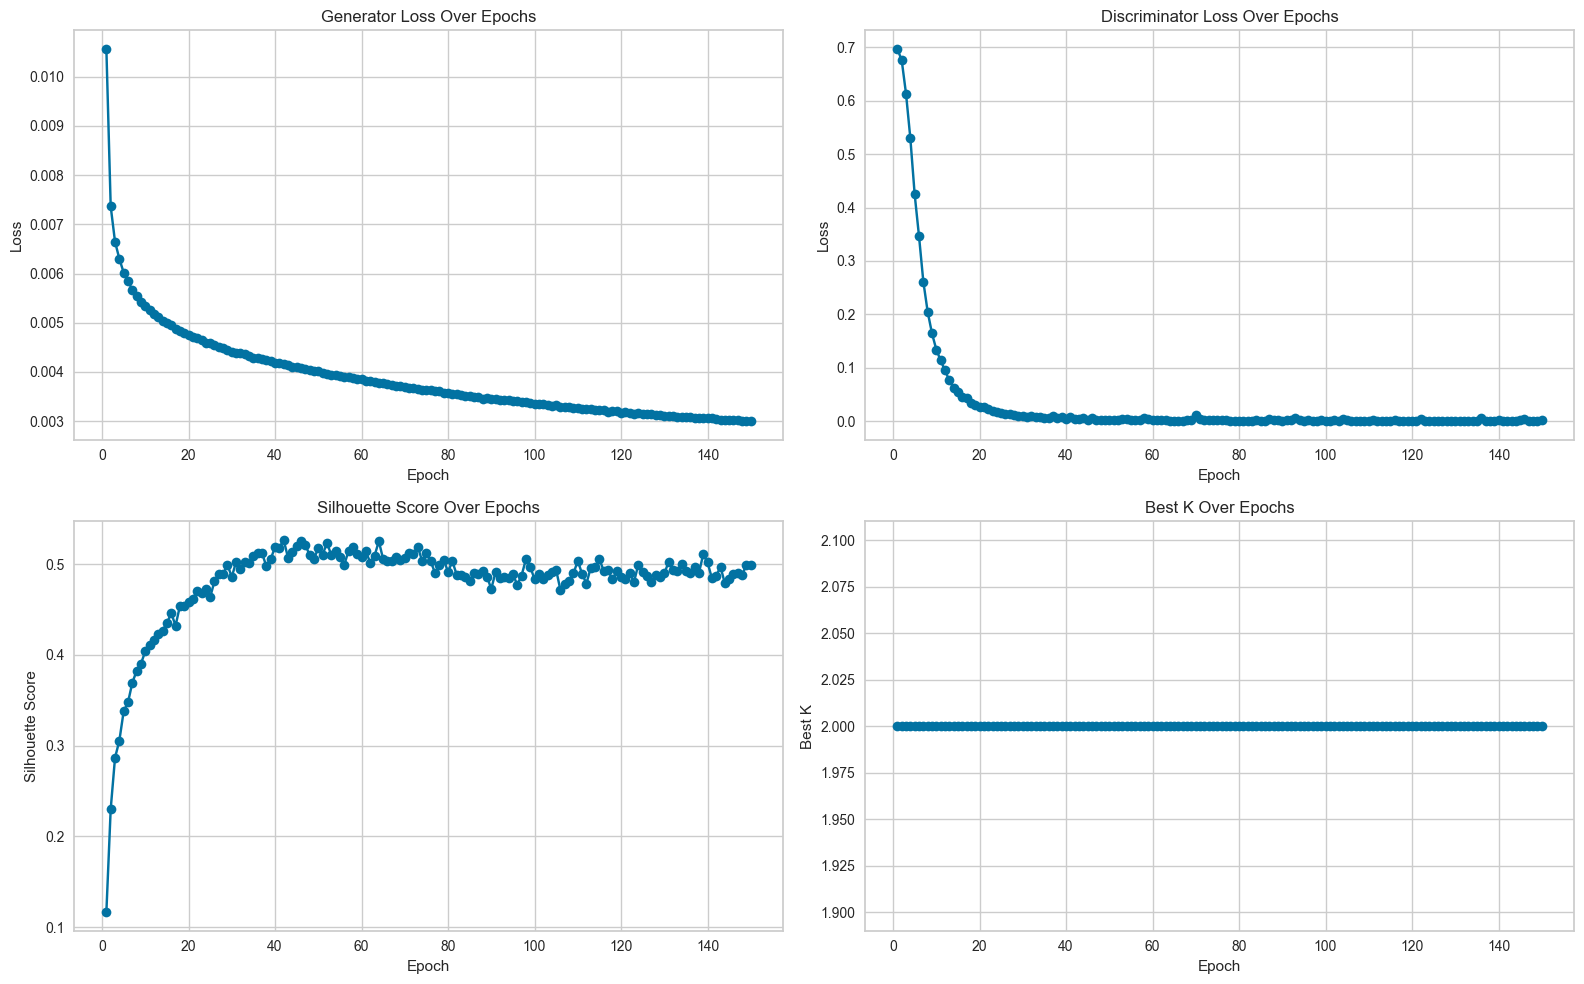

In [39]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, len(losses_G)+1), losses_G, marker='o')
plt.title("Generator Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(2, 2, 2)
plt.plot(range(1, len(losses_D)+1), losses_D, marker='o')
plt.title("Discriminator Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(2, 2, 3)
plt.plot(range(1, len(sil_scores)+1), sil_scores, marker='o')
plt.title("Silhouette Score Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Silhouette Score")

plt.subplot(2, 2, 4)
plt.plot(range(1, len(cluster_counts)+1), cluster_counts, marker='o')
plt.title("Best K Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Best K")

plt.tight_layout()
plt.show()

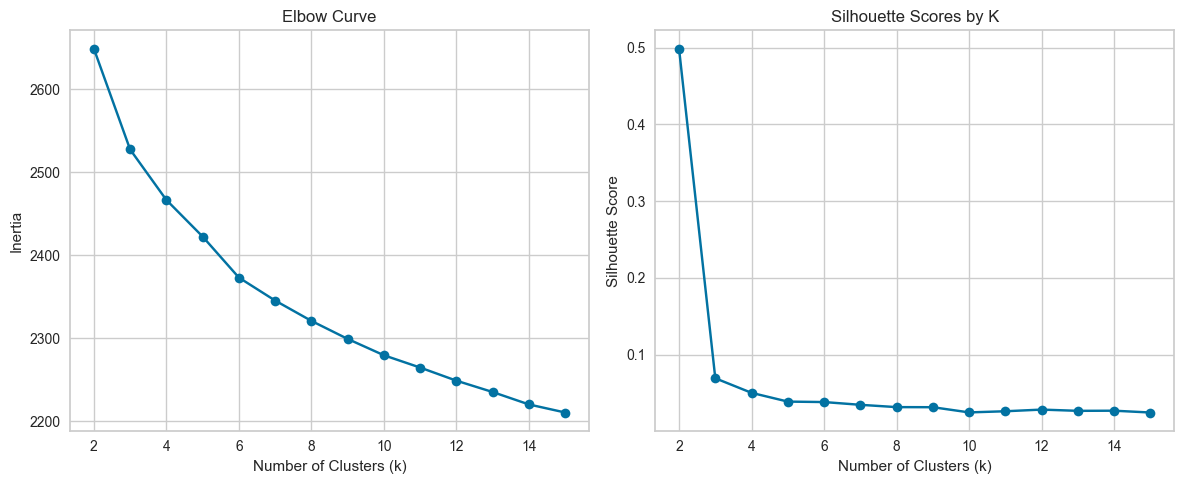

In [40]:
all_latent_final = torch.cat(latent_epoch).numpy()
inertias = []
silhouettes = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(all_latent_final)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(all_latent_final, kmeans.labels_))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Curve")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouettes, marker='o')
plt.title("Silhouette Scores by K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.tight_layout()
plt.show()


In [41]:
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', random_state=42)
labels_spectral = spectral.fit_predict(all_latent_final)
score_spectral = silhouette_score(all_latent_final, labels_spectral)
print(f"Spectral Clustering Silhouette Score: {score_spectral:.4f}")
agglo = AgglomerativeClustering(n_clusters=3)
labels_agglo = agglo.fit_predict(all_latent_final)
score_agglo = silhouette_score(all_latent_final, labels_agglo)
print(f"Hierarchical Clustering Silhouette Score: {score_agglo:.4f}")

Spectral Clustering Silhouette Score: 0.3891
Hierarchical Clustering Silhouette Score: 0.2813


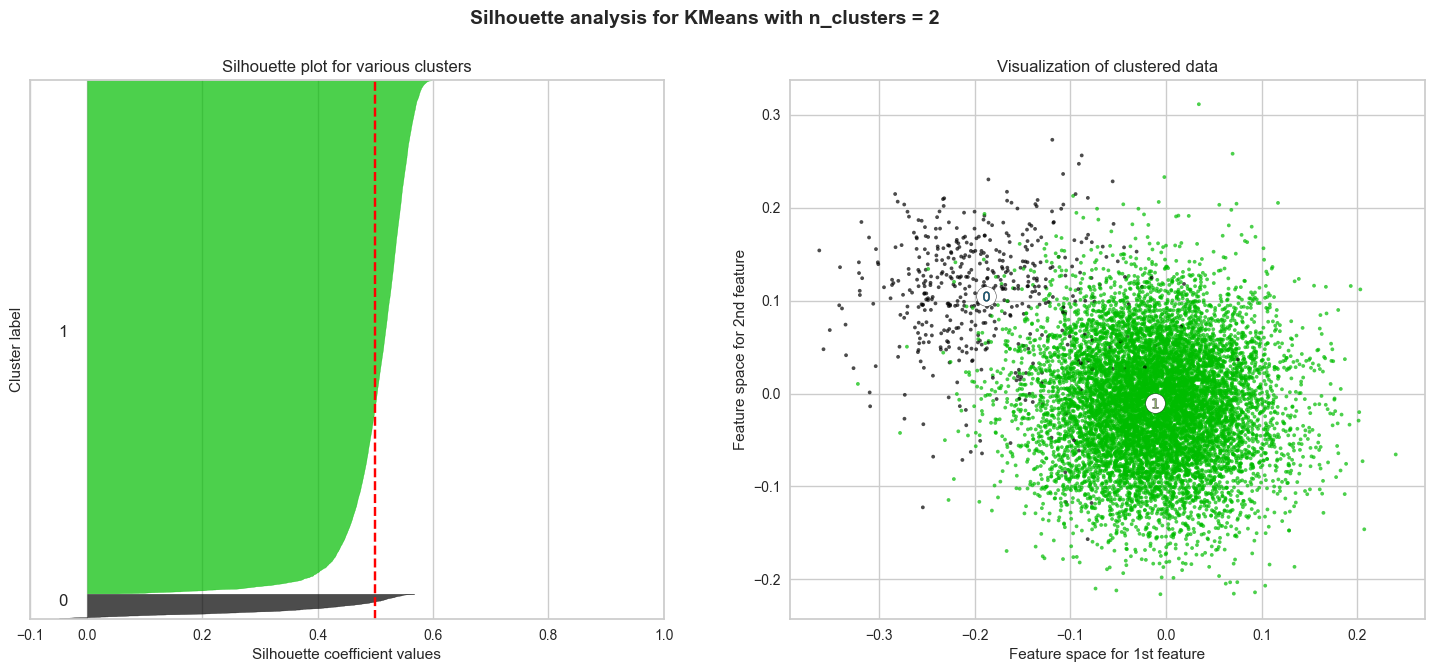

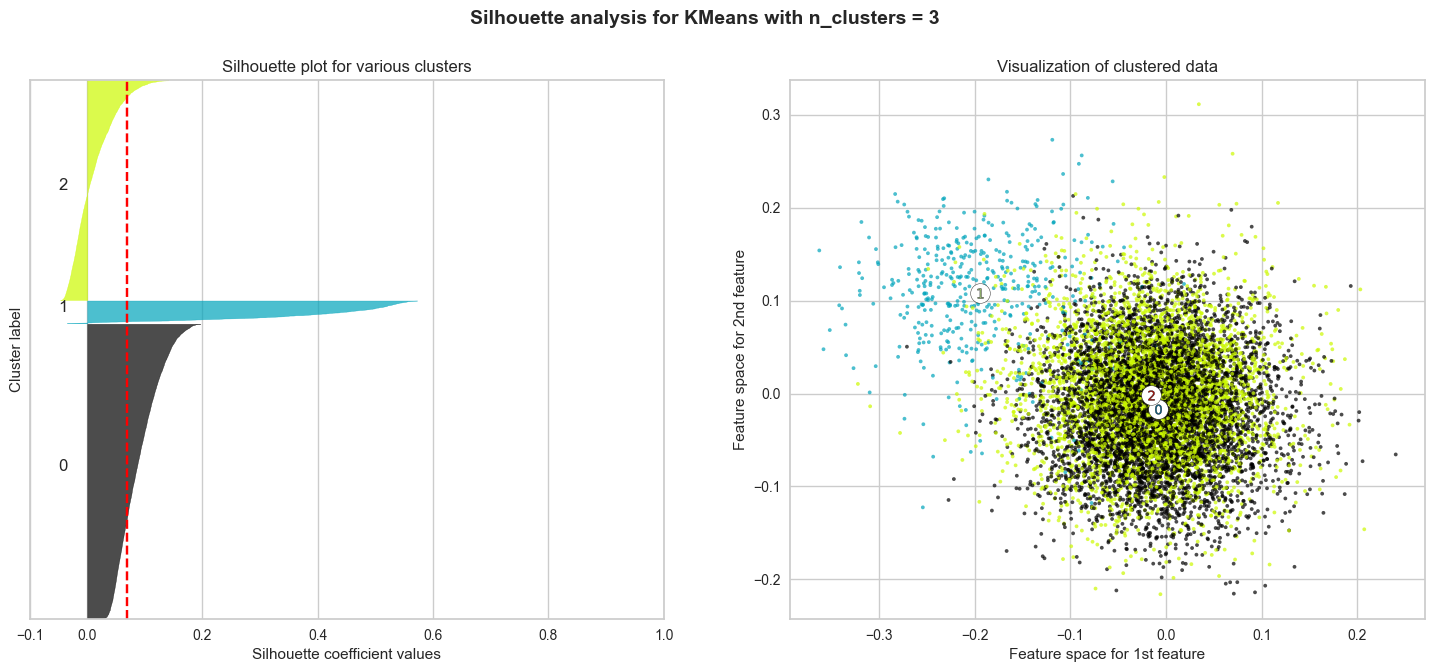

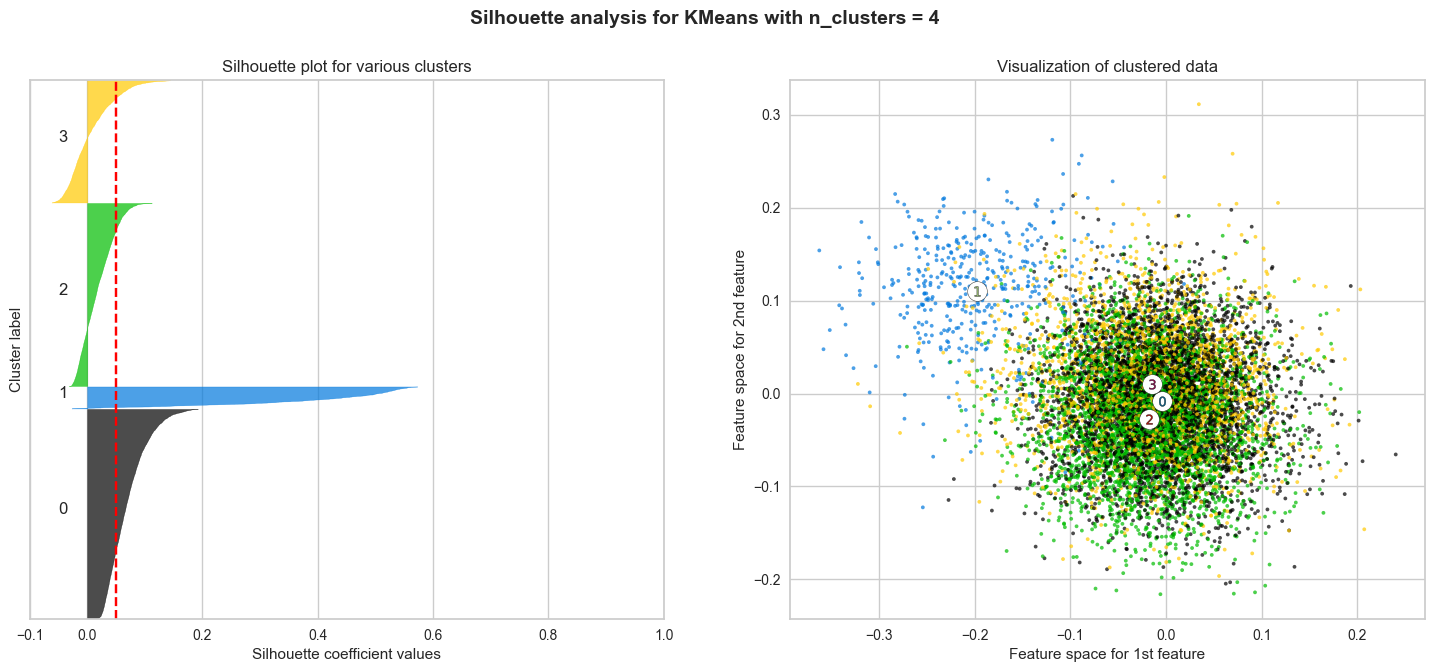

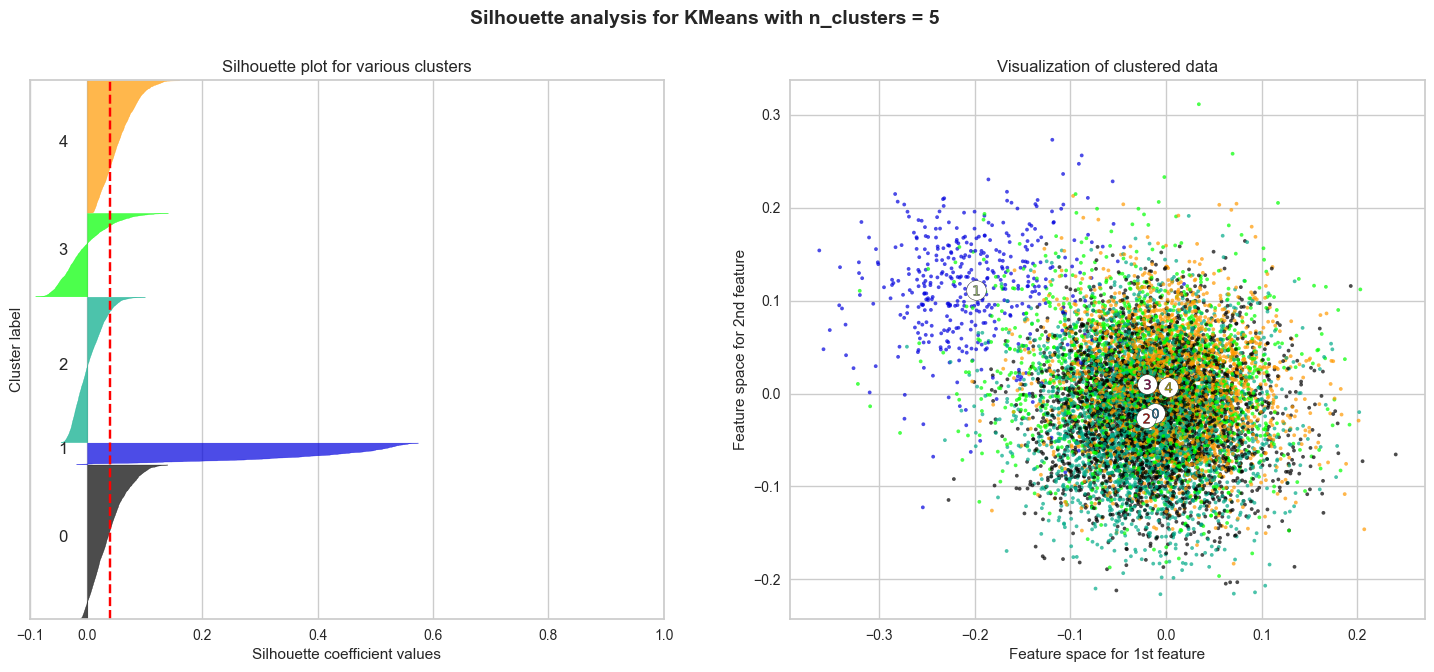

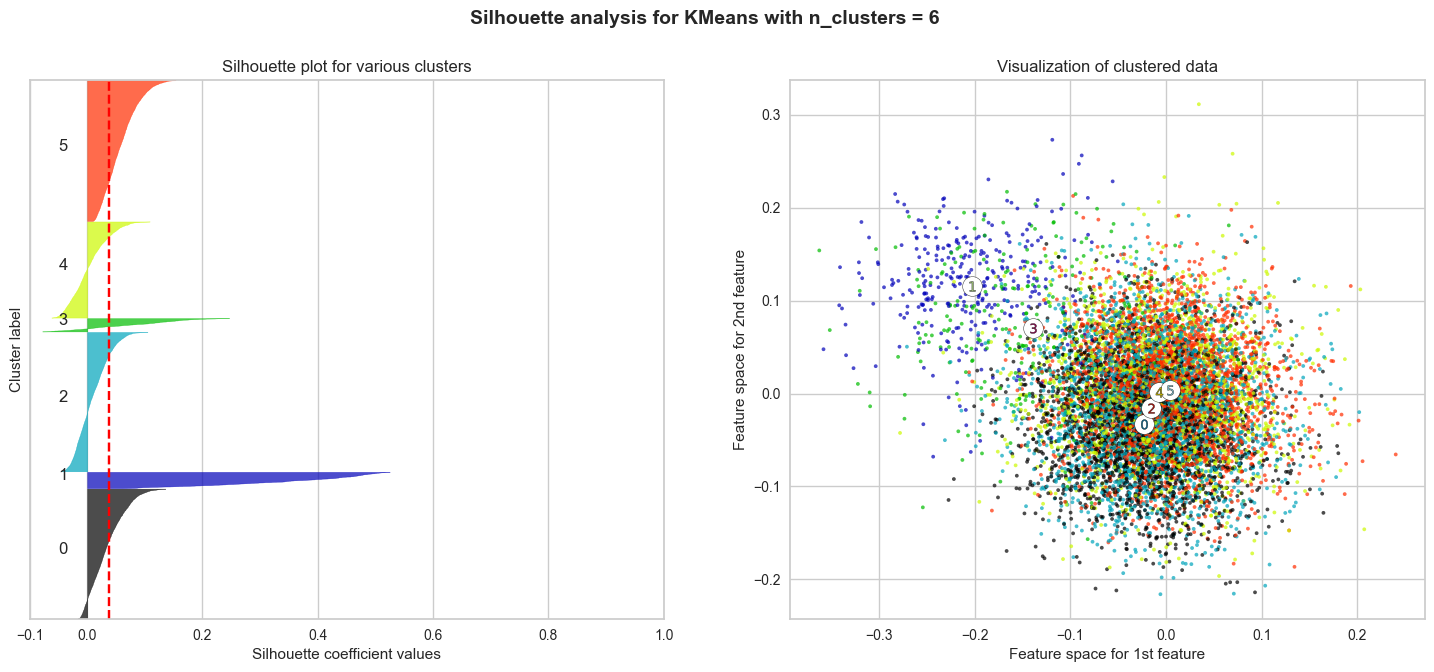

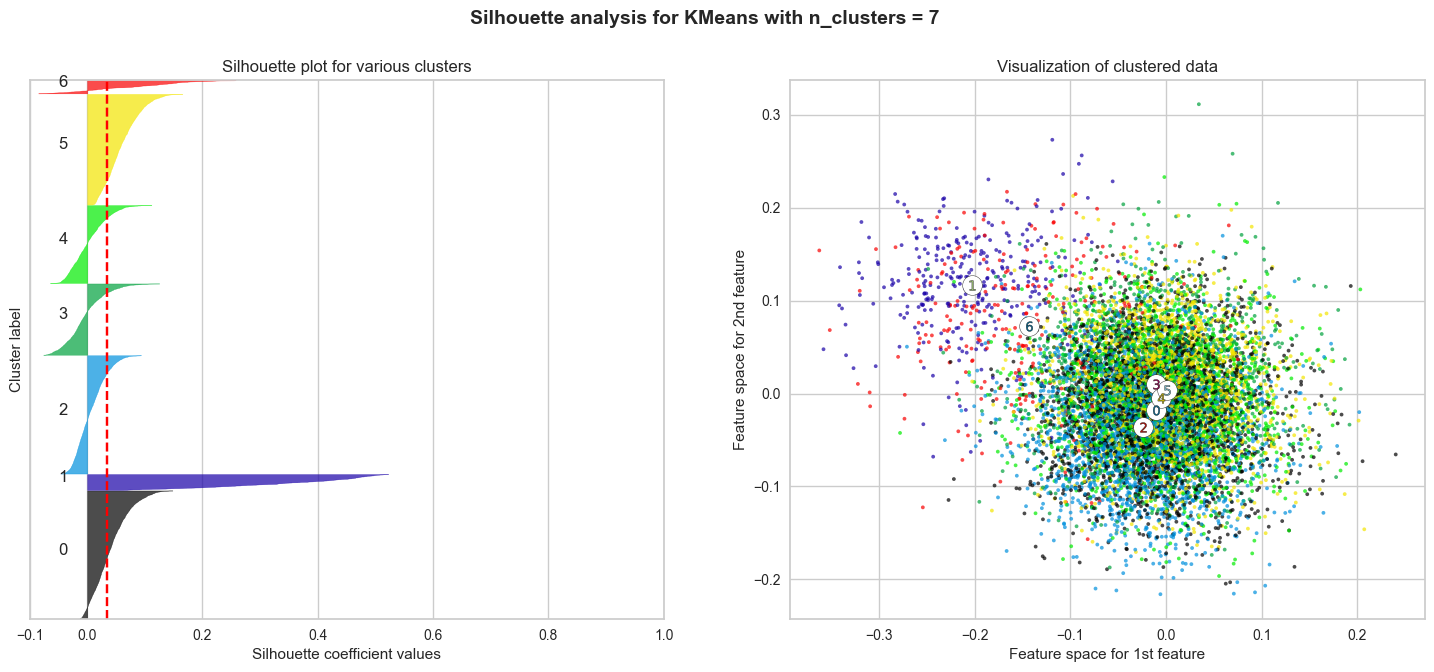

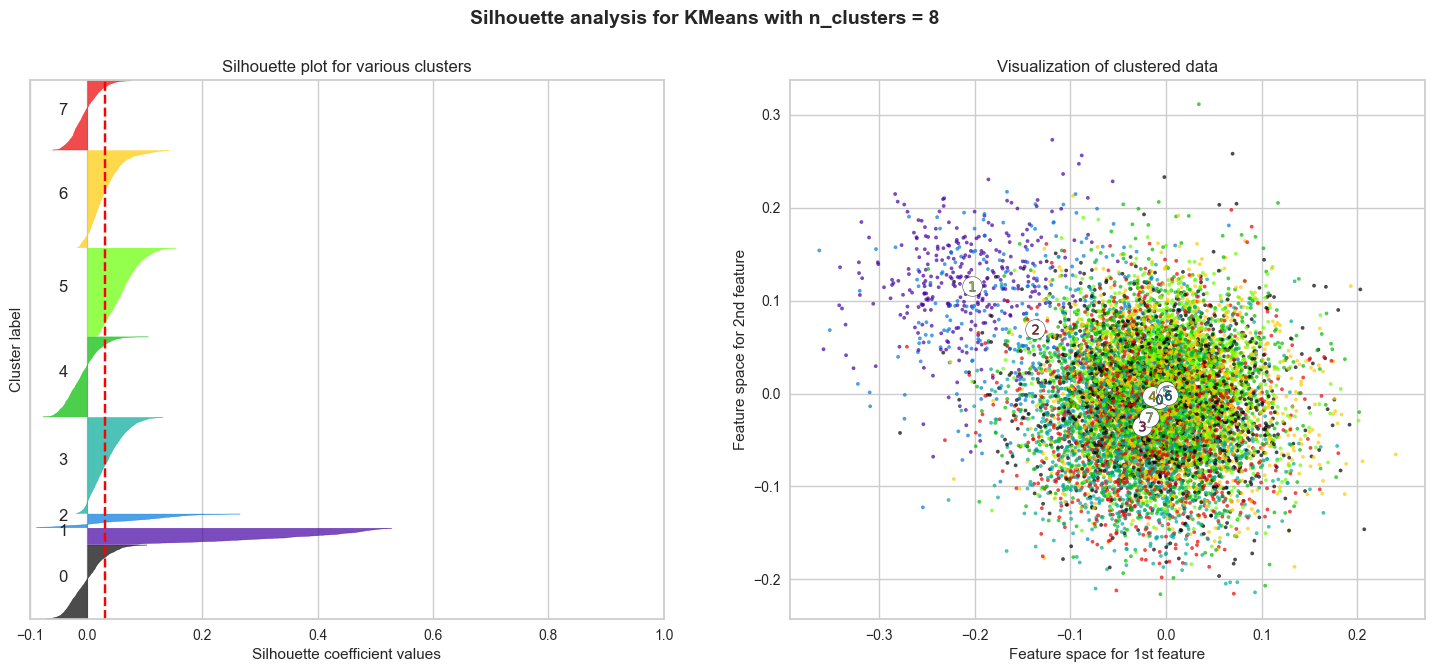

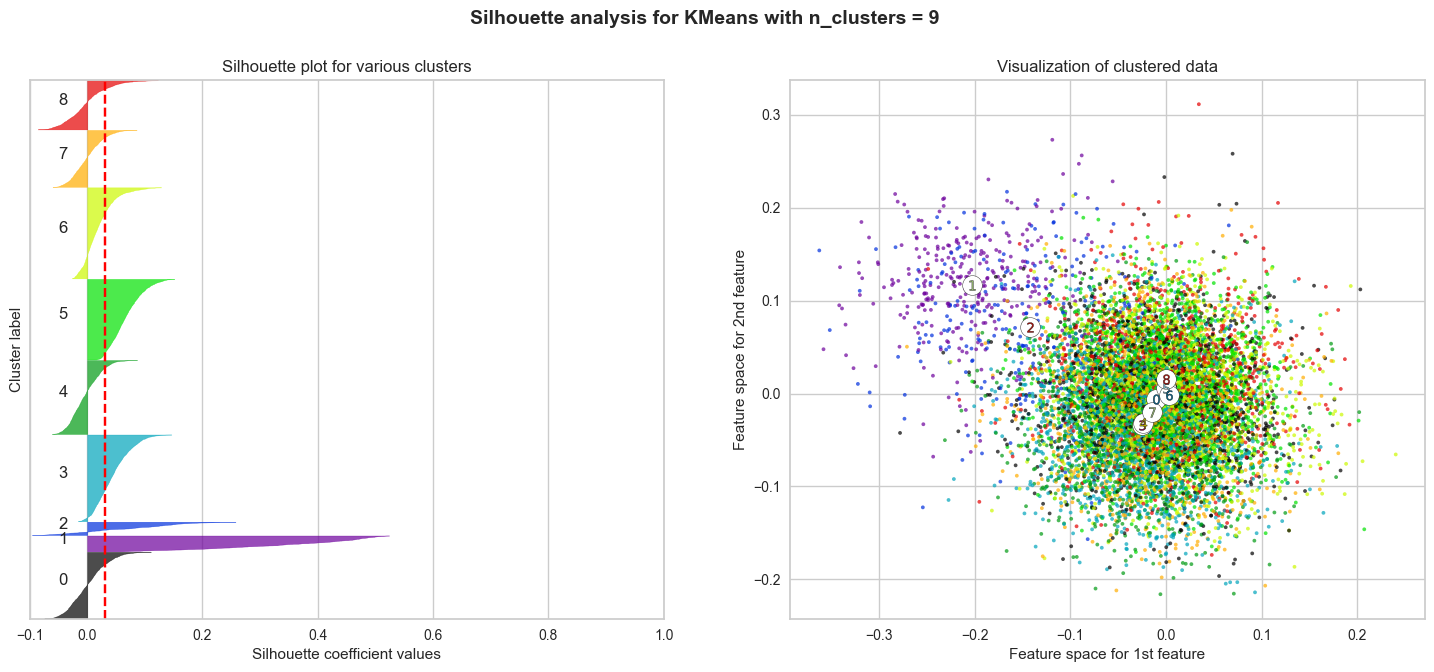

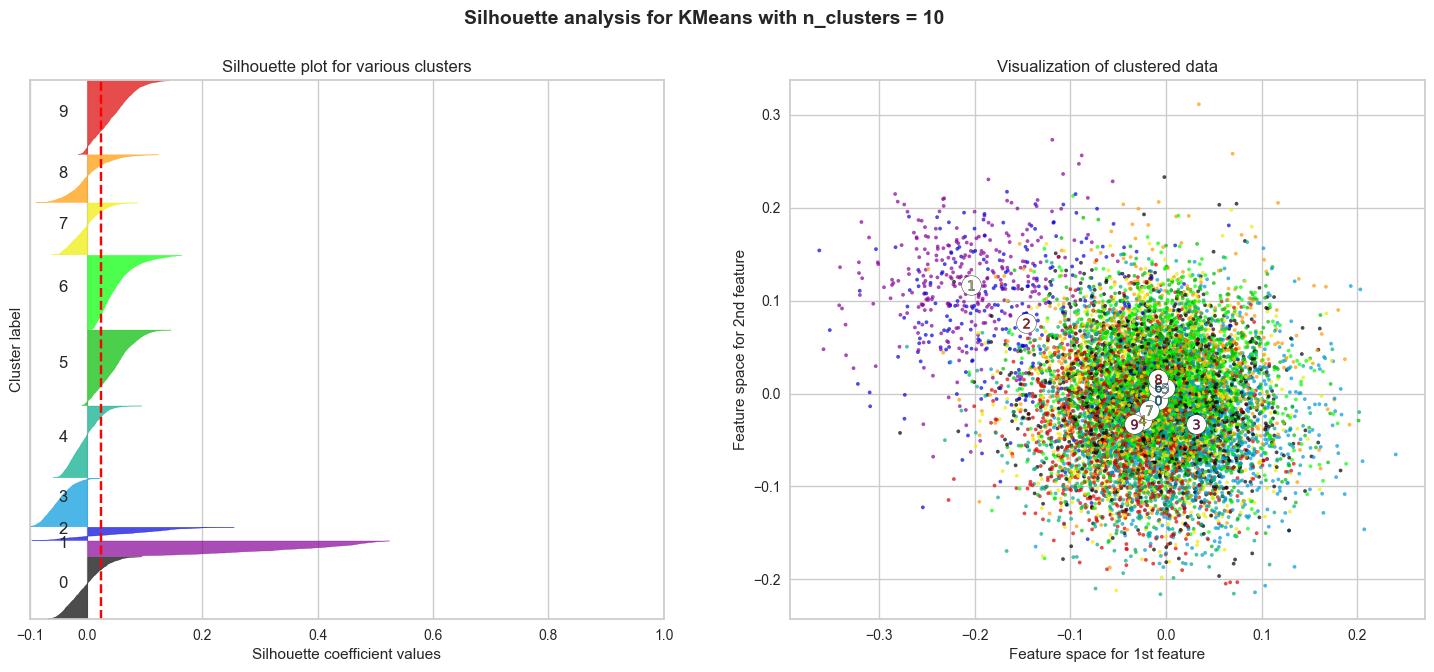

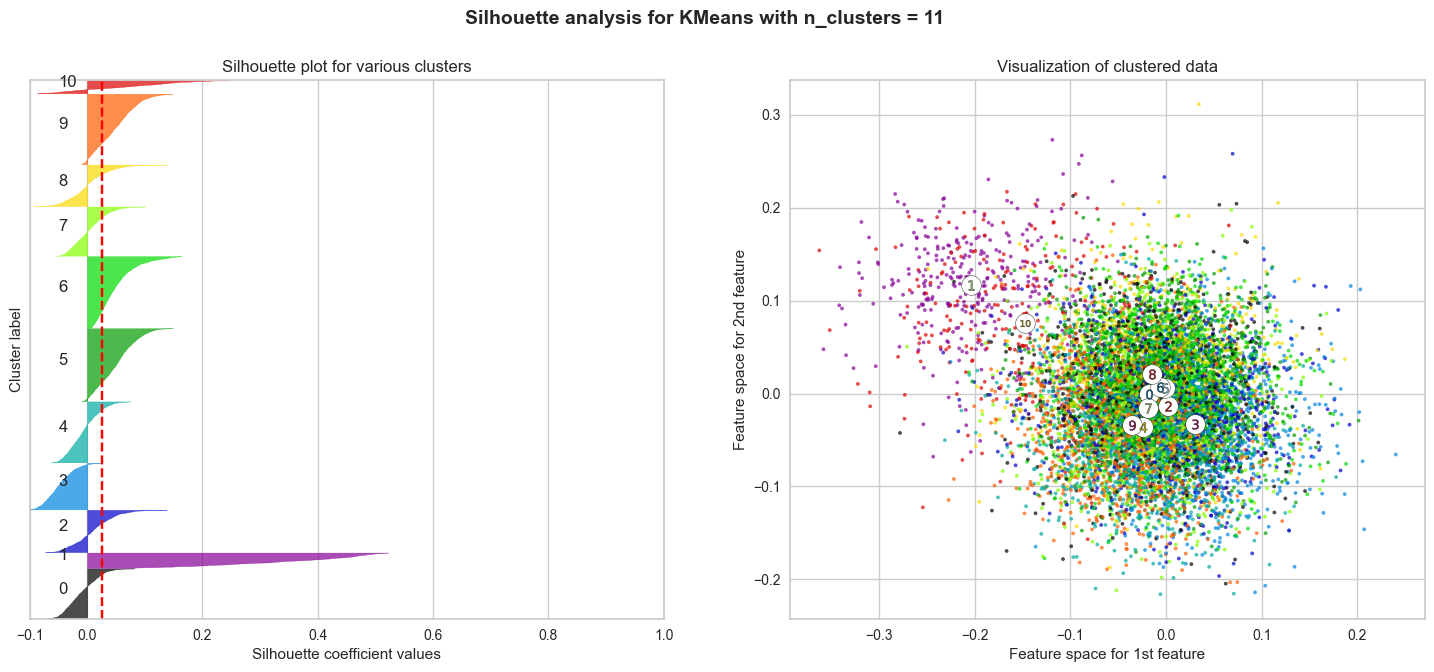

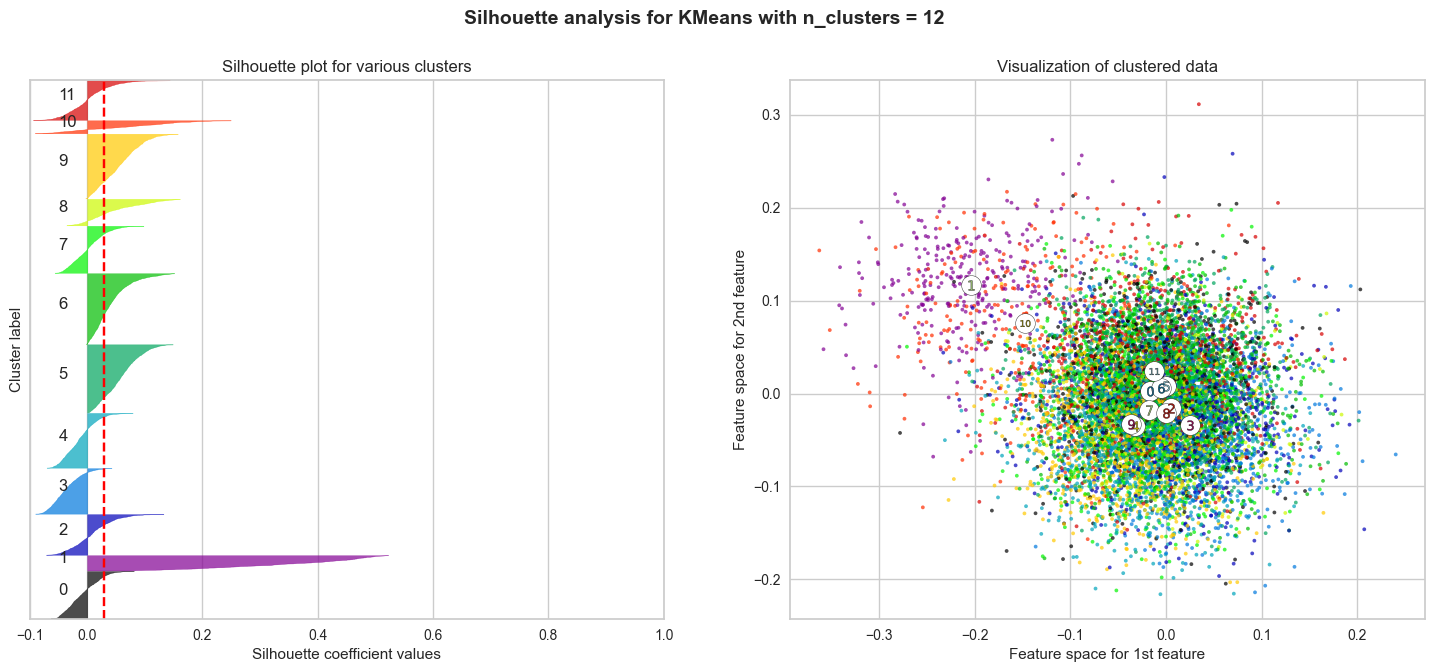

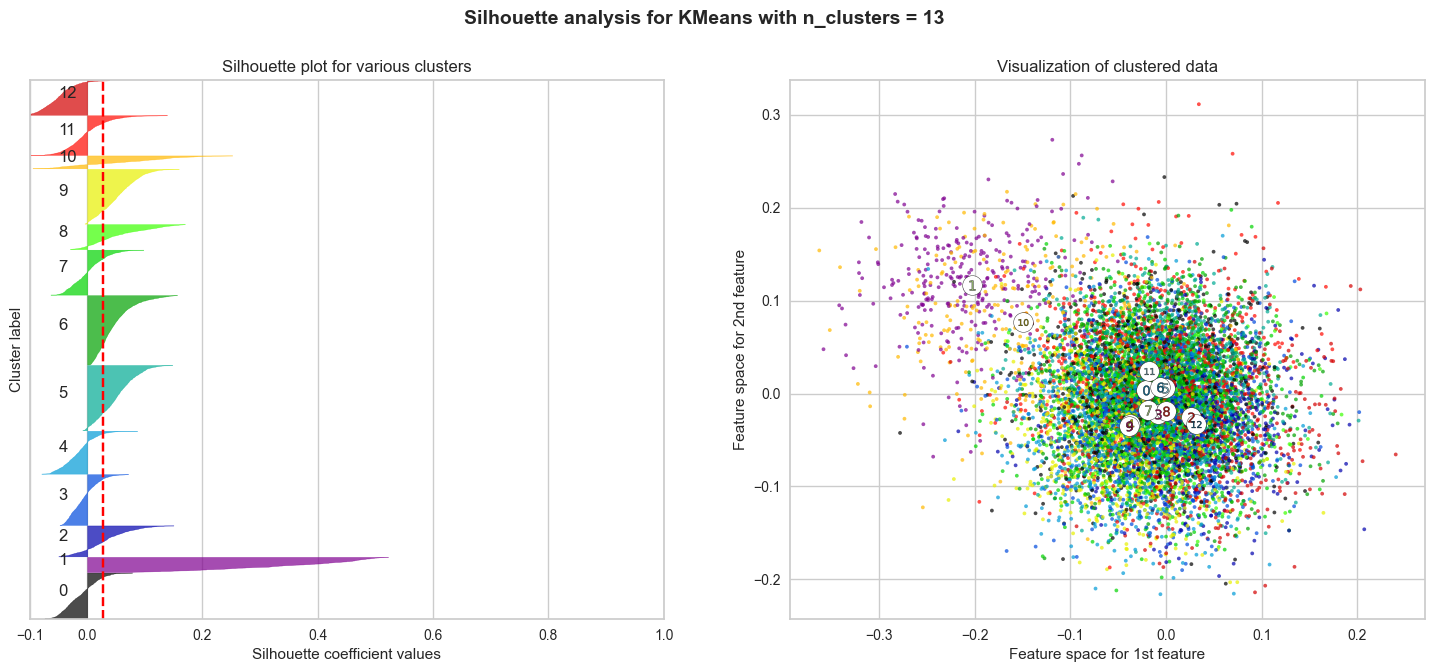

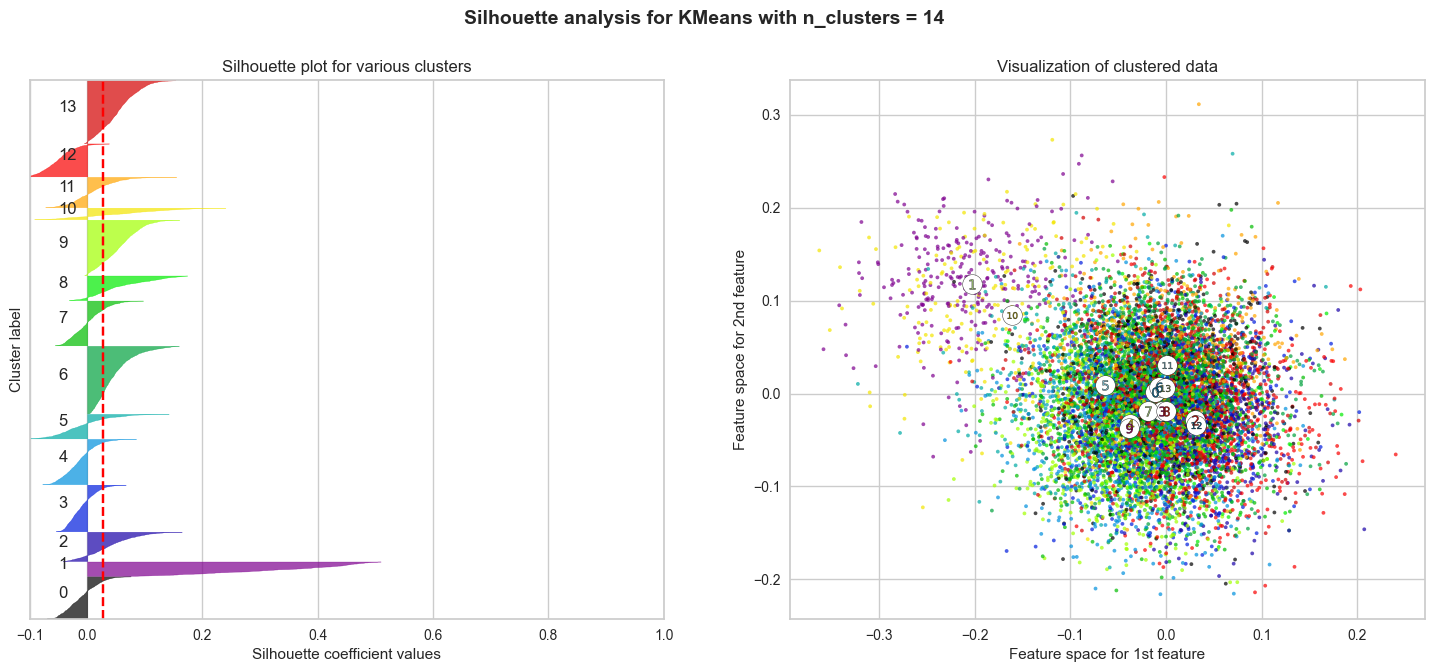

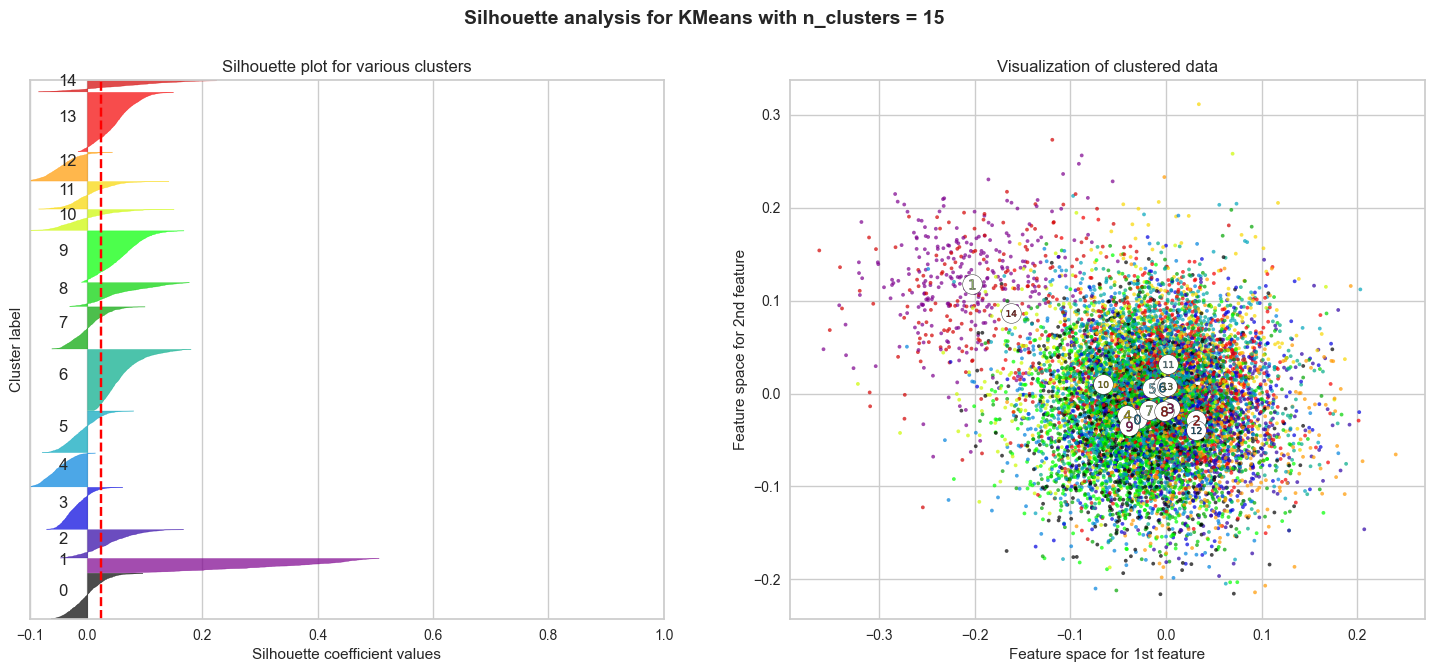

In [42]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(all_latent_final) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(all_latent_final)

    silhouette_avg = silhouette_score(all_latent_final, cluster_labels)
    sample_silhouette_values = silhouette_samples(all_latent_final, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for various clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        all_latent_final[:, 0], all_latent_final[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k"
    )
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of clustered data")
    ax2.set_xlabel("Feature space for 1st feature")
    ax2.set_ylabel("Feature space for 2nd feature")
    plt.suptitle(f"Silhouette analysis for KMeans with n_clusters = {n_clusters}", fontsize=14, fontweight="bold")

plt.show()

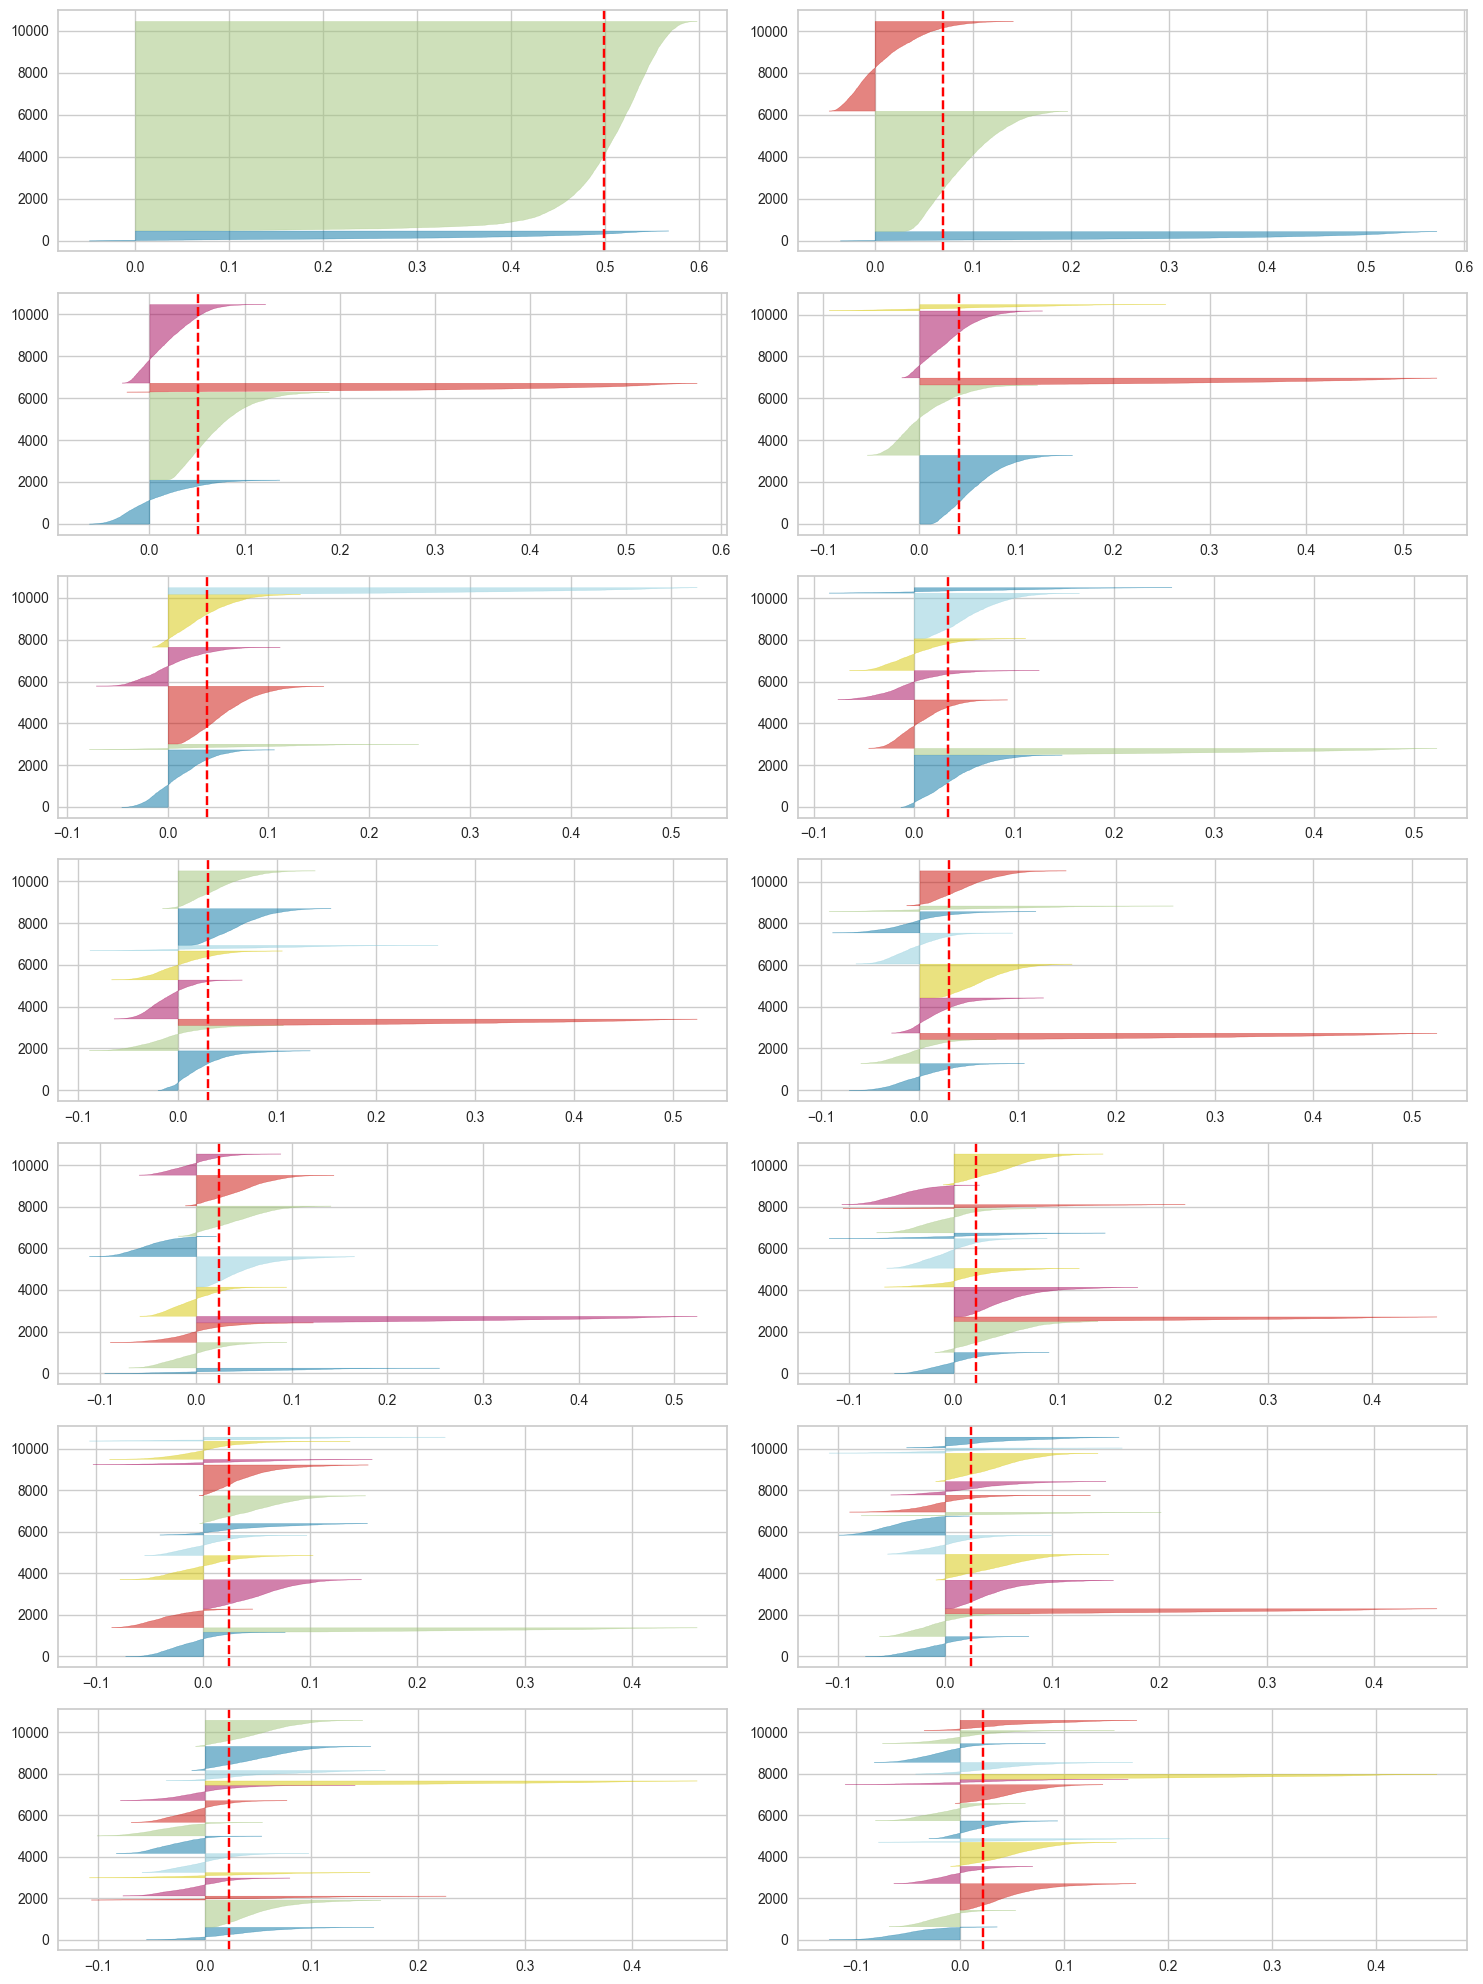

In [43]:
fig, ax = plt.subplots(7, 2, figsize=(15, 20))
for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(all_latent_final)
plt.tight_layout()
plt.show()

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
X = merged_scaled
y = cluster_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(10))


              precision    recall  f1-score   support

           0       0.10      0.14      0.11       261
           1       0.00      0.00      0.00        77
           2       0.03      0.01      0.01       179
           3       0.07      0.06      0.07       237
           4       0.04      0.01      0.02       204
           5       0.10      0.07      0.08       243
           6       0.12      0.28      0.17       381
           7       0.09      0.06      0.07       253
           8       0.17      0.01      0.01       160
           9       0.10      0.12      0.11       324
          10       0.00      0.00      0.00       116
          11       0.00      0.00      0.00       145
          12       0.09      0.01      0.01       164
          13       0.11      0.27      0.16       329
          14       0.00      0.00      0.00        63

    accuracy                           0.10      3136
   macro avg       0.07      0.07      0.05      3136
weighted avg       0.08   

In [45]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(10))


TCGA.MP.A4SW.01    0.002781
TCGA.NJ.A4YQ.01    0.002614
TCGA.69.7760.01    0.002544
TCGA.64.5775.01    0.002536
TCGA.80.5607.01    0.002531
TCGA.97.A4LX.01    0.002517
TCGA.38.6178.01    0.002513
TCGA.86.8280.01    0.002505
TCGA.78.7542.01    0.002502
TCGA.80.5611.01    0.002498
dtype: float64


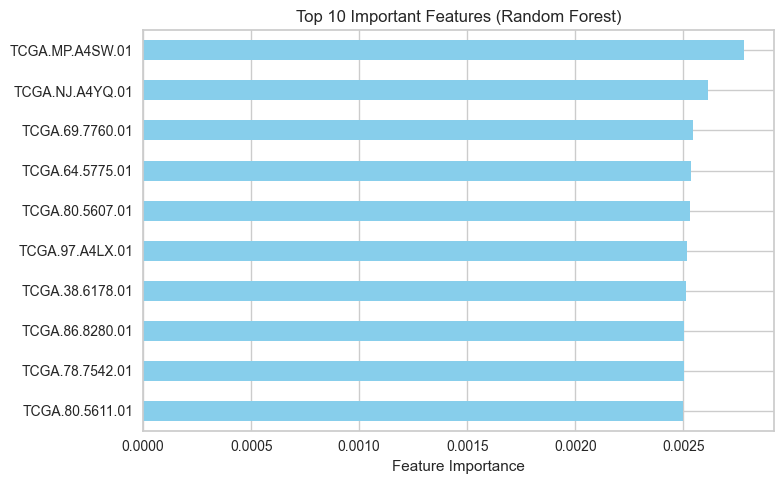

In [46]:
top_features = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
top_features.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()  
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()


In [47]:
omics_labels = []
for gene in top_features.index:
    if gene in mRNA.columns:
        omics_labels.append("mRNA")
    elif gene in CNV.columns:
        omics_labels.append("CNV")
    elif gene in miRNA.columns:
        omics_labels.append("miRNA")
    elif gene in Methy.columns:
        omics_labels.append("Methy")
    else:
        omics_labels.append("Unknown")
for gene, imp, source in zip(top_features.index, top_features.values, omics_labels):
    print(f"{gene:<20}  {source:<6}  Importance: {imp:.5f}")
omics_labels = []
for gene in top_features.index:
    if gene in mRNA.columns:
        omics_labels.append("mRNA")
    elif gene in CNV.columns:
        omics_labels.append("CNV")
    elif gene in miRNA.columns:
        omics_labels.append("miRNA")
    elif gene in Methy.columns:
        omics_labels.append("Methy")
    else:
        omics_labels.append("Unknown")
for gene, imp, source in zip(top_features.index, top_features.values, omics_labels):
    print(f"{gene:<20}  {source:<6}  Importance: {imp:.5f}")


TCGA.MP.A4SW.01       mRNA    Importance: 0.00278
TCGA.NJ.A4YQ.01       mRNA    Importance: 0.00261
TCGA.69.7760.01       mRNA    Importance: 0.00254
TCGA.64.5775.01       mRNA    Importance: 0.00254
TCGA.80.5607.01       mRNA    Importance: 0.00253
TCGA.97.A4LX.01       mRNA    Importance: 0.00252
TCGA.38.6178.01       mRNA    Importance: 0.00251
TCGA.86.8280.01       mRNA    Importance: 0.00251
TCGA.78.7542.01       mRNA    Importance: 0.00250
TCGA.80.5611.01       mRNA    Importance: 0.00250
TCGA.MP.A4SW.01       mRNA    Importance: 0.00278
TCGA.NJ.A4YQ.01       mRNA    Importance: 0.00261
TCGA.69.7760.01       mRNA    Importance: 0.00254
TCGA.64.5775.01       mRNA    Importance: 0.00254
TCGA.80.5607.01       mRNA    Importance: 0.00253
TCGA.97.A4LX.01       mRNA    Importance: 0.00252
TCGA.38.6178.01       mRNA    Importance: 0.00251
TCGA.86.8280.01       mRNA    Importance: 0.00251
TCGA.78.7542.01       mRNA    Importance: 0.00250
TCGA.80.5611.01       mRNA    Importance: 0.00250


In [48]:
top10_genes = importances.sort_values(ascending=False).head(10).index.tolist()


In [49]:
omics_labels = []
for gene in top10_genes:
    if gene in mRNA.columns:
        omics_labels.append("mRNA")
    elif gene in CNV.columns:
        omics_labels.append("CNV")
    elif gene in miRNA.columns:
        omics_labels.append("miRNA")
    elif gene in Methy.columns:
        omics_labels.append("Methy")
    else:
        omics_labels.append("Unknown")

for gene, source in zip(top10_genes, omics_labels):
    print(f"{gene:<20} → {source}")


TCGA.MP.A4SW.01      → mRNA
TCGA.NJ.A4YQ.01      → mRNA
TCGA.69.7760.01      → mRNA
TCGA.64.5775.01      → mRNA
TCGA.80.5607.01      → mRNA
TCGA.97.A4LX.01      → mRNA
TCGA.38.6178.01      → mRNA
TCGA.86.8280.01      → mRNA
TCGA.78.7542.01      → mRNA
TCGA.80.5611.01      → mRNA


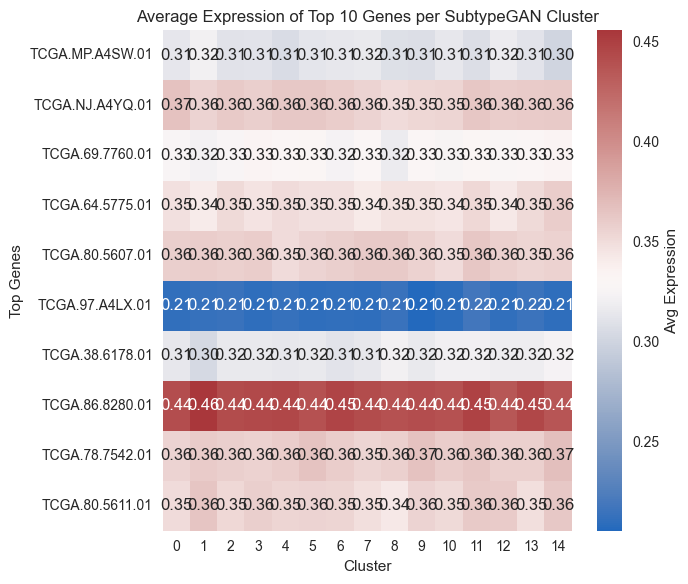

In [50]:
top10_genes = importances.sort_values(ascending=False).head(10).index.tolist()
df_clustered = merged_scaled[top10_genes].copy()
df_clustered["Cluster"] = cluster_labels
cluster_means = df_clustered.groupby("Cluster").mean().T

plt.figure(figsize=(7, 6))
sns.heatmap(cluster_means, cmap="vlag", annot=True, fmt=".2f", cbar_kws={"label": "Avg Expression"})
plt.title("Average Expression of Top 10 Genes per SubtypeGAN Cluster")
plt.xlabel("Cluster")
plt.ylabel("Top Genes")
plt.tight_layout()
plt.show()


In [53]:
def top_variable_genes(df, top_n=500):
    variances = df.var(axis=1)
    top_genes = variances.sort_values(ascending=False).head(top_n).index
    return df.loc[top_genes]

cnv_top = top_variable_genes(df_cnv_z, 500)
mrna_top = top_variable_genes(df_mrna_z, 500)
mirna_top = top_variable_genes(df_mirna_z, 250)
methy_top = top_variable_genes(df_methy_z, 250)

multiomics_top = pd.concat([cnv_top, mrna_top, mirna_top, methy_top], axis=0)

X_multi_top = multiomics_top.T
X_multi_top = X_multi_top.dropna(axis=1)
X_multi_top.shape
print(X_multi_top.isna().sum().sum())

0


Epoch 1/150, Loss: 0.9930
Epoch 2/150, Loss: 0.8958
Epoch 3/150, Loss: 0.8447
Epoch 4/150, Loss: 0.8059
Epoch 5/150, Loss: 0.7753
Epoch 6/150, Loss: 0.7549
Epoch 7/150, Loss: 0.7357
Epoch 8/150, Loss: 0.7263
Epoch 9/150, Loss: 0.7073
Epoch 10/150, Loss: 0.6967
Epoch 11/150, Loss: 0.6868
Epoch 12/150, Loss: 0.6784
Epoch 13/150, Loss: 0.6659
Epoch 14/150, Loss: 0.6518
Epoch 15/150, Loss: 0.6465
Epoch 16/150, Loss: 0.6406
Epoch 17/150, Loss: 0.6296
Epoch 18/150, Loss: 0.6202
Epoch 19/150, Loss: 0.6112
Epoch 20/150, Loss: 0.6036
Epoch 21/150, Loss: 0.5989
Epoch 22/150, Loss: 0.5939
Epoch 23/150, Loss: 0.5877
Epoch 24/150, Loss: 0.5830
Epoch 25/150, Loss: 0.5734
Epoch 26/150, Loss: 0.5674
Epoch 27/150, Loss: 0.5678
Epoch 28/150, Loss: 0.5597
Epoch 29/150, Loss: 0.5590
Epoch 30/150, Loss: 0.5503
Epoch 31/150, Loss: 0.5414
Epoch 32/150, Loss: 0.5382
Epoch 33/150, Loss: 0.5314
Epoch 34/150, Loss: 0.5275
Epoch 35/150, Loss: 0.5233
Epoch 36/150, Loss: 0.5206
Epoch 37/150, Loss: 0.5145
Epoch 38/1

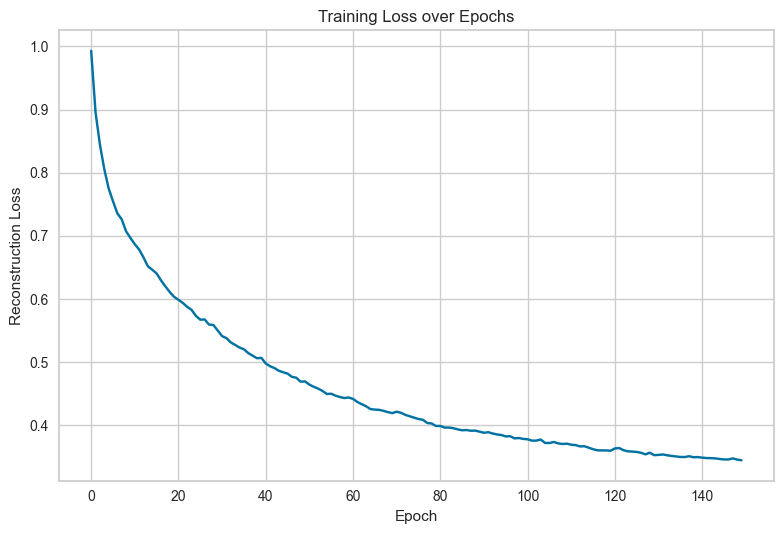

Silhouette Score: 0.11922685


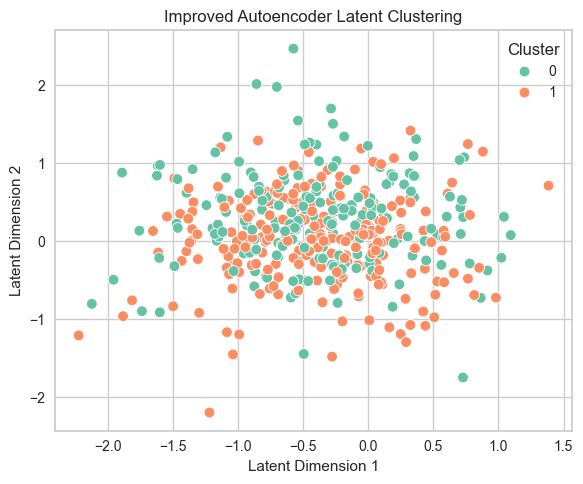

In [54]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

X = X_multi_top.dropna().copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

class Autoencoder_1(nn.Module):
    def __init__(self, input_dim, latent_dim=12):
        super(Autoencoder_1, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder_1(input_dim=X_scaled.shape[1], latent_dim=12)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

losses = []
for epoch in range(150):
    model.train()
    total_loss = 0
    for batch in loader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    scheduler.step(avg_loss)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/150, Loss: {avg_loss:.4f}")

plt.figure()
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    Z = model.encoder(X_tensor).numpy()

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(Z)
score = silhouette_score(Z, clusters)
print("Silhouette Score:", score)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=Z[:, 0], y=Z[:, 1], hue=clusters, palette="Set2", s=60)
plt.title("Improved Autoencoder Latent Clustering")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


Epoch 1/300, Loss: 0.9601
Epoch 2/300, Loss: 0.8256
Epoch 3/300, Loss: 0.7653
Epoch 4/300, Loss: 0.7326
Epoch 5/300, Loss: 0.7016
Epoch 6/300, Loss: 0.6723
Epoch 7/300, Loss: 0.6558
Epoch 8/300, Loss: 0.6294
Epoch 9/300, Loss: 0.6091
Epoch 10/300, Loss: 0.5958
Epoch 11/300, Loss: 0.5733
Epoch 12/300, Loss: 0.5528
Epoch 13/300, Loss: 0.5361
Epoch 14/300, Loss: 0.5249
Epoch 15/300, Loss: 0.5112
Epoch 16/300, Loss: 0.4911
Epoch 17/300, Loss: 0.4734
Epoch 18/300, Loss: 0.4602
Epoch 19/300, Loss: 0.4492
Epoch 20/300, Loss: 0.4362
Epoch 21/300, Loss: 0.4236
Epoch 22/300, Loss: 0.4099
Epoch 23/300, Loss: 0.4012
Epoch 24/300, Loss: 0.3896
Epoch 25/300, Loss: 0.3803
Epoch 26/300, Loss: 0.3700
Epoch 27/300, Loss: 0.3649
Epoch 28/300, Loss: 0.3576
Epoch 29/300, Loss: 0.3488
Epoch 30/300, Loss: 0.3398
Epoch 31/300, Loss: 0.3324
Epoch 32/300, Loss: 0.3280
Epoch 33/300, Loss: 0.3228
Epoch 34/300, Loss: 0.3140
Epoch 35/300, Loss: 0.3043
Epoch 36/300, Loss: 0.2952
Epoch 37/300, Loss: 0.2943
Epoch 38/3

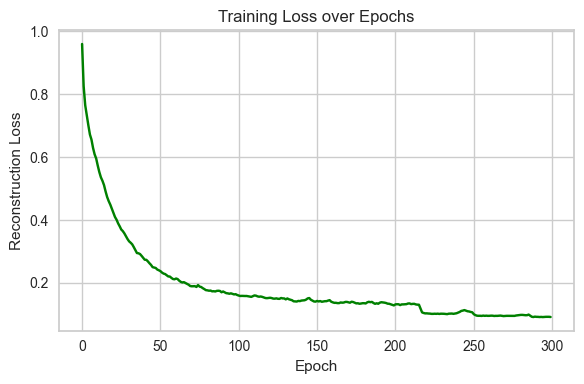

Silhouette Score: 0.0701


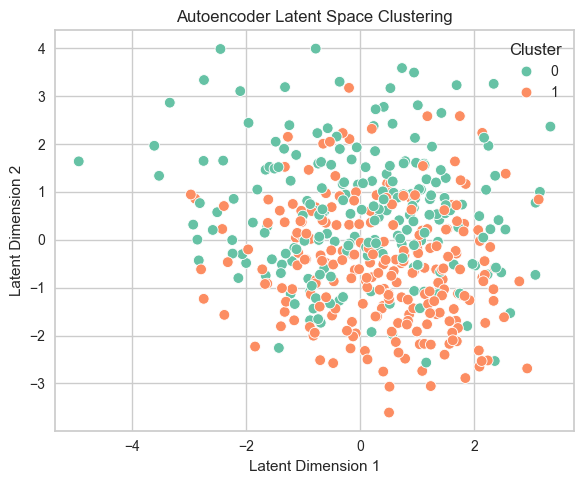

In [55]:
class Autoencoder_2(nn.Module):
    def __init__(self, input_dim, latent_dim=20):
        super(Autoencoder_2, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Linear(128, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Linear(128, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

model = Autoencoder_2(input_dim=X_scaled.shape[1], latent_dim=20)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

losses = []
for epoch in range(300):
    model.train()
    total_loss = 0
    for batch in loader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(loader)
    scheduler.step(avg_loss)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/300, Loss: {avg_loss:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(losses, color='green')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    Z = model.encoder(X_tensor).numpy()

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(Z)

score = silhouette_score(Z, clusters)
print("Silhouette Score:", round(score, 4))

plt.figure(figsize=(6, 5))
sns.scatterplot(x=Z[:, 0], y=Z[:, 1], hue=clusters, palette="Set2", s=60)
plt.title("Autoencoder Latent Space Clustering")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [58]:
survival_df

survival_times
event_observed                
0                        426.0
0                       1126.0
1                        303.0
0                        610.0
0                          0.0
...                        ...
0                        617.0
1                       1798.0
0                        513.0
1                       1097.0
0                       4694.0

[450 rows x 1 columns]

In [70]:
X = merged_scaled.iloc[survival_df.index][top_features.index]
y_time = survival_df['survival_times']
y_event = pd.Series(survival_df.index, index=survival_df.index)

X_train, X_test, y_train_time, y_test_time, y_train_event, y_test_event = train_test_split(
    X, y_time, y_event, test_size=0.3, random_state=42
)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_time_tensor = torch.tensor(y_train_time.values, dtype=torch.float32)
y_train_event_tensor = torch.tensor(y_train_event.values, dtype=torch.float32)


Epoch 1/300, Loss: 4.1003
Epoch 2/300, Loss: 4.2172
Epoch 3/300, Loss: 4.3029
Epoch 4/300, Loss: 4.1696
Epoch 5/300, Loss: 4.1982
Epoch 6/300, Loss: 4.0644
Epoch 7/300, Loss: 3.8335
Epoch 8/300, Loss: 3.5678
Epoch 9/300, Loss: 4.3096
Epoch 10/300, Loss: 4.1518
Epoch 11/300, Loss: 3.7857
Epoch 12/300, Loss: 4.5990
Epoch 13/300, Loss: 4.0947
Epoch 14/300, Loss: 4.2104
Epoch 15/300, Loss: 4.4301
Epoch 16/300, Loss: 3.5174
Epoch 17/300, Loss: 4.5006
Epoch 18/300, Loss: 4.3777
Epoch 19/300, Loss: 3.7773
Epoch 20/300, Loss: 4.0504
Epoch 21/300, Loss: 4.0081
Epoch 22/300, Loss: 3.8939
Epoch 23/300, Loss: 3.8349
Epoch 24/300, Loss: 4.1122
Epoch 25/300, Loss: 4.2160
Epoch 26/300, Loss: 4.4503
Epoch 27/300, Loss: 4.0328
Epoch 28/300, Loss: 3.9025
Epoch 29/300, Loss: 4.3433
Epoch 30/300, Loss: 3.6201
Epoch 31/300, Loss: 3.5996
Epoch 32/300, Loss: 3.3182
Epoch 33/300, Loss: 4.1252
Epoch 34/300, Loss: 3.5849
Epoch 35/300, Loss: 3.6259
Epoch 36/300, Loss: 3.5666
Epoch 37/300, Loss: 3.6992
Epoch 38/3

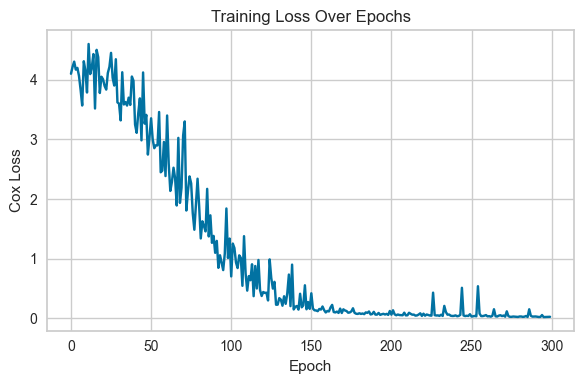


 Concordance Index on Test Set: 0.4588


In [72]:
class DeepSurv_1(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurv_1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = DeepSurv_1(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

def cox_ph_loss(log_hazard, time, event):
    hazard_ratio = torch.exp(log_hazard)
    log_risk = torch.log(torch.cumsum(hazard_ratio.flip(0), dim=0).flip(0))
    uncensored_likelihood = log_hazard - log_risk
    censored_mask = event == 1
    neg_log_likelihood = -torch.sum(uncensored_likelihood[censored_mask]) / torch.sum(censored_mask)
    return neg_log_likelihood

num_epochs = 300
losses = []
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    log_hazard = model(X_train_tensor).squeeze()
    loss = cox_ph_loss(log_hazard, y_train_time_tensor, y_train_event_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Cox Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    mask = (~np.isnan(y_test_time)) & (~np.isnan(risk_scores)) & (~np.isnan(y_test_event))
    risk_scores = risk_scores[mask]
    y_test_time_filtered = y_test_time[mask]
    y_test_event_filtered = y_test_event[mask]

    c_index = concordance_index(y_test_time_filtered, -risk_scores, y_test_event_filtered)
    print(f"\n Concordance Index on Test Set: {c_index:.4f}")

Epoch 1/100, Loss: 1.0235
Epoch 2/100, Loss: 1.0169
Epoch 3/100, Loss: 1.0126
Epoch 4/100, Loss: 1.0107
Epoch 5/100, Loss: 1.0089
Epoch 6/100, Loss: 1.0075
Epoch 7/100, Loss: 1.0066
Epoch 8/100, Loss: 1.0055
Epoch 9/100, Loss: 1.0051
Epoch 10/100, Loss: 1.0047
Epoch 11/100, Loss: 1.0041
Epoch 12/100, Loss: 1.0037
Epoch 13/100, Loss: 1.0036
Epoch 14/100, Loss: 1.0032
Epoch 15/100, Loss: 1.0031
Epoch 16/100, Loss: 1.0028
Epoch 17/100, Loss: 1.0027
Epoch 18/100, Loss: 1.0025
Epoch 19/100, Loss: 1.0022
Epoch 20/100, Loss: 1.0021
Epoch 21/100, Loss: 1.0020
Epoch 22/100, Loss: 1.0020
Epoch 23/100, Loss: 1.0019
Epoch 24/100, Loss: 1.0017
Epoch 25/100, Loss: 1.0016
Epoch 26/100, Loss: 1.0015
Epoch 27/100, Loss: 1.0014
Epoch 28/100, Loss: 1.0013
Epoch 29/100, Loss: 1.0013
Epoch 30/100, Loss: 1.0014
Epoch 31/100, Loss: 1.0011
Epoch 32/100, Loss: 1.0012
Epoch 33/100, Loss: 1.0011
Epoch 34/100, Loss: 1.0011
Epoch 35/100, Loss: 1.0010
Epoch 36/100, Loss: 1.0010
Epoch 37/100, Loss: 1.0010
Epoch 38/1

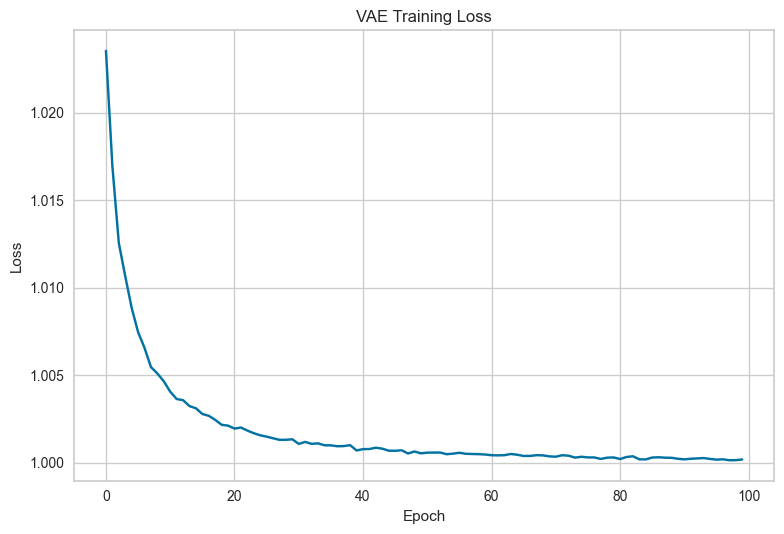


Extracted latent shape: (450, 20)


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

class VAE_Model(nn.Module):
    def __init__(self, input_dim, latent_dim=20):
        super(VAE_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

vae_model = VAE_Model(input_dim=X_scaled.shape[1], latent_dim=20)
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
epochs = 100
vae_model.train()
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    recon, mu, logvar = vae_model(X_tensor)
    loss = vae_loss(recon, X_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

plt.plot(losses)
plt.title("VAE Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

vae_model.eval()
with torch.no_grad():
    mu, _ = vae_model.encode(X_tensor)
    Z = mu.numpy()

print(f"\nExtracted latent shape: {Z.shape}")


Epoch 1/150, Loss: 1.0028, Beta: 0.00
Epoch 2/150, Loss: 1.0018, Beta: 0.03
Epoch 3/150, Loss: 1.0017, Beta: 0.07
Epoch 4/150, Loss: 1.0016, Beta: 0.10
Epoch 5/150, Loss: 1.0013, Beta: 0.13
Epoch 6/150, Loss: 1.0012, Beta: 0.17
Epoch 7/150, Loss: 1.0010, Beta: 0.20
Epoch 8/150, Loss: 1.0009, Beta: 0.23
Epoch 9/150, Loss: 1.0008, Beta: 0.27
Epoch 10/150, Loss: 1.0006, Beta: 0.30
Epoch 11/150, Loss: 1.0007, Beta: 0.33
Epoch 12/150, Loss: 1.0008, Beta: 0.37
Epoch 13/150, Loss: 1.0006, Beta: 0.40
Epoch 14/150, Loss: 1.0008, Beta: 0.43
Epoch 15/150, Loss: 1.0006, Beta: 0.47
Epoch 16/150, Loss: 1.0008, Beta: 0.50
Epoch 17/150, Loss: 1.0005, Beta: 0.53
Epoch 18/150, Loss: 1.0005, Beta: 0.57
Epoch 19/150, Loss: 1.0006, Beta: 0.60
Epoch 20/150, Loss: 1.0005, Beta: 0.63
Epoch 21/150, Loss: 1.0003, Beta: 0.67
Epoch 22/150, Loss: 1.0004, Beta: 0.70
Epoch 23/150, Loss: 1.0003, Beta: 0.73
Epoch 24/150, Loss: 1.0001, Beta: 0.77
Epoch 25/150, Loss: 1.0002, Beta: 0.80
Epoch 26/150, Loss: 1.0003, Beta: 

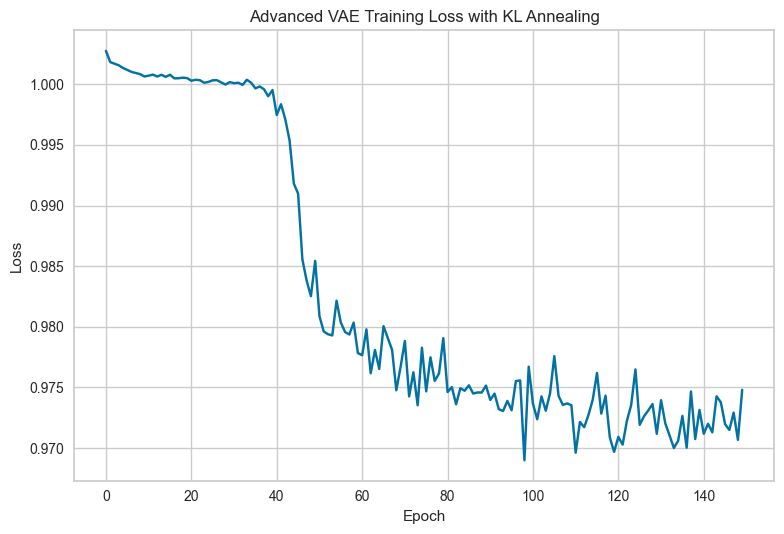

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

class VAE_Advanced(nn.Module):
    def __init__(self, input_dim, latent_dim=50):
        super(VAE_Advanced, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.LeakyReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div

vae_model = VAE_Advanced(input_dim=X_scaled.shape[1], latent_dim=50)
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)

epochs = 150
losses = []
for epoch in range(epochs):
    vae_model.train()
    optimizer.zero_grad()
    recon, mu, logvar = vae_model(X_tensor)
    beta = min(1.0, epoch / 30)
    loss = vae_loss(recon, X_tensor, mu, logvar, beta)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Beta: {beta:.2f}")

plt.plot(losses)
plt.title("Advanced VAE Training Loss with KL Annealing")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.grid(True)
plt.show()

vae_model.eval()
with torch.no_grad():
    Z = vae_model.encode(X_tensor)[0].numpy()